The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3070 Laptop GPU


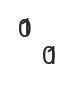

In [111]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
# pd.set_option("display.max_columns",999)
# pd.set_option("display.max_rows",100)

import warnings
warnings.filterwarnings("ignore")

import src.models
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import encode_batch_weighted, onehot_batch_decode, onehot_decode, INT_TO_CHAR, HLAS, AA_KEYS
from src.data_processing import get_tensor_dataset, encode_batch, BL62_VALUES, BL62FREQ_VALUES, get_array_dataset
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from src.metrics import get_metrics, plot_roc_auc_fold, get_mean_roc_curve, get_pred_df, get_mean_pr_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.train_eval import kcv_tune_sklearn, evaluate_trained_models_sklearn, nested_kcv_train_sklearn
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump

from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

RESDIR='../output/220906_analysis/'
BOOTDIR='../output/bootstrapping/'

if torch.cuda.is_available():
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device="cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'
    

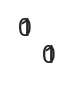

In [2]:
mpl.rcParams['figure.dpi'] = 180
sns.set_palette(HSV)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

# init

## reloading datasets

In [3]:
cedar = pd.read_csv('../data/partitioned_traindata/cedar_10fold.csv')
cedar['trainset']='cedar'

cedar_viral_old = pd.read_csv('../data/partitioned_traindata/cedar_viral_10fold.csv')
cedar_viral_old['trainset']='cedar_virus_old'

cedar_viral_more = pd.read_csv('../data/partitioned_traindata/new_cedar_viral_5fold.csv')
cedar_viral_more['trainset']='cedar_virus_new'
# USE PRIME FOR BASELINE VERIFICATION, PRIME_FOLD FOR ACTUAL TRAINING
prime_fold = pd.read_csv('../data/partitioned_traindata/prime_5fold.csv')
prime_fold['trainset']='prime'

prime = pd.read_excel('../data/partitioned_traindata/PRIME_dataset.xlsx', comment = '#', skiprows=2)
prime['len'] = prime['Mutant'].apply(len)
prime['HLA'] = prime['Allele'].apply(lambda x: 'HLA-'+x)

viral_only = pd.read_csv('../data/partitioned_traindata/viral_only_5fold.csv')
viral_only['trainset']='virus'

cedar_hp_uni = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_rank120_10fold.csv')
cedar_hp_uni['trainset']='cedar_hp_rank_uni'

cedar_hp_low = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_10fold.csv')
cedar_hp_low['trainset']='cedar_hp_rank_low'

cedar_hp_fold = pd.read_csv('../data/partitioned_traindata/cedar_hp_fold_balanced.csv')
cedar_hp_fold['trainset'] = 'cedar_balanced'

cedar_mut_fold = pd.read_csv('../data/partitioned_traindata/cedar_subst_mut_10fold.csv')

In [4]:
cedar_related = pd.read_csv('../data/mutant/220927_cedar_related_scored.csv')
prime_related = pd.read_csv('../data/mutant/220927_prime_neoepi_related_scored.csv')

In [5]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

## Baselines

3480


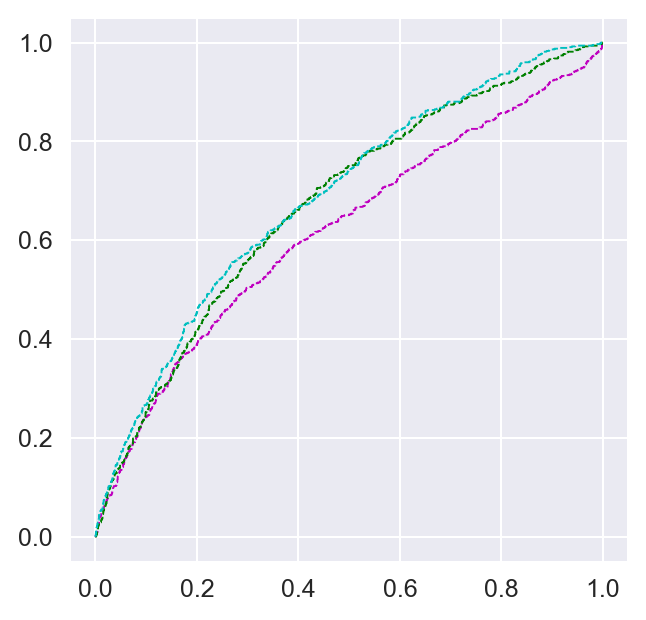

In [6]:
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
cedar_baseline = pd.read_csv('../data/baselines/cedar_baseline.csv')
cedar_related_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime = pd.read_csv('../data/baselines/prime_baseline.csv')
prime_related_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')
f,a = plt.subplots(1,1, figsize=(4,4))
plot_baseline_roc(a, cedar_baseline)

In [7]:
prime_related.columns.difference(prime_related_baseline.columns)

Index(['Allele', 'IEDB', 'Immunogenicity', 'MixMHCpred', 'NetMHCpanEL',
       'NetMHCpanEL_WT', 'PRIME', 'VHSE1', 'VHSE3', 'VHSE7', 'VHSE8',
       'aliphatic_index', 'boman', 'hydrophobicity', 'isoelectric_point'],
      dtype='object')

# Redefine anchor/netmhcpan for old dump

## reading

In [83]:
cedar_related_fold = pd.read_csv('../data/partitioned_traindata/cedar_subst_mut_10fold.csv')
print(len(cedar_related_fold))
cedar_related_fold.head()

3033


,Peptide,wild_type,len,HLA,trueHLA_EL_rank,wt_EL_rank,ratio_rank,fold,agg_label,binder,anchor_mutation,mutation_position,mutation_type,mutation_score,blsm_mut_score,BA_rank,BA_score,HLA_full,PMIDs,Related Object_Ending Position,Related Object_Starting Position,core,core_mutation_position,delta_VHSE1,delta_VHSE3,delta_VHSE7,delta_VHSE8,delta_aliphatic_index,delta_boman,delta_hydrophobicity,delta_isoelectric_point,delta_rank,icore,label,len_wt,mhc_anchor,percentage_pos,pred_EL_rank,pred_EL_score,pred_HLA,responses,total_count,trainset,wt_core,wt_true
0,AAAAAAQQIQV,AAAAAAQQLQV,11,HLA-B0702,26.7692,25.5667,0.955079,6,0,Conserved,0,8,substitution,1.386294,1.386294,11.9024,0.1632,HLA-B*07:02,27198675,167.0,157.0,AAAAAQIQV,6,-0.008182,-0.005455,-0.021818,0.044545,0.000000,0.000000,0.063636,0.0,-1.2025,AAAAAAQQIQV,Negative,11,"1,8",0.0,5.2822,0.0166,HLA-A68:02,Negative,1,cedar,AAAAAQLQV,True
1,AAAAQQIQV,AAAAQQLQV,9,HLA-A0201,1.9555,2.2847,1.168346,6,0,Conserved,0,6,substitution,1.386294,1.386294,0.3045,0.4709,HLA-A*02:01,27198675,167.0,159.0,AAAAQQIQV,6,-0.010000,-0.006667,-0.026667,0.054444,0.000000,0.000000,0.077778,0.0,0.3292,AAAAQQIQV,Negative,9,"1,3,8",0.0,0.1036,0.6567,HLA-C15:02,Negative,1,cedar,AAAAQQLQV,True
2,AAAAQQIQV,AAAAQQLQV,9,HLA-B0702,4.9092,4.7746,0.972582,6,0,Conserved,0,6,substitution,1.386294,1.386294,0.3045,0.4709,HLA-B*07:02,27198675,167.0,159.0,AAAAQQIQV,6,-0.010000,-0.006667,-0.026667,0.054444,0.000000,0.000000,0.077778,0.0,-0.1346,AAAAQQIQV,Negative,9,"1,8",0.0,0.1036,0.6567,HLA-C15:02,Negative,1,cedar,AAAAQQLQV,True
3,AAHFTVLLY,AAHFTALLY,9,HLA-A1101,0.4196,0.5881,1.401573,8,0,Conserved,0,5,substitution,1.386294,1.386294,0.1083,0.6509,HLA-A*11:01,31511069,1957.0,1949.0,AAHFTVLLY,5,0.067778,0.131111,-0.066667,0.050000,21.111111,-0.247778,0.266667,0.0,0.1685,AAHFTVLLY,Negative,9,"0,1,8",0.0,0.0256,0.8170,HLA-A30:02,Negative,1,cedar,AAHFTALLY,True
4,AAIAASRSV,AAIAASRSA,9,HLA-C1203,0.0591,1.1729,19.846024,7,0,Improved,1,8,substitution,1.386294,1.386294,0.0580,0.7400,HLA-C*12:03,30556813,14.0,6.0,AAIAASRSV,8,0.067778,0.131111,-0.066667,0.050000,21.111111,-0.247778,0.266667,0.0,1.1138,AAIAASRSV,Negative,9,"1,8",0.0,0.0591,0.6191,HLA-C12:03,Negative,1,cedar,AAIAASRSA,True


## Writing into ""fasta"" file

In [11]:
','.join(sorted(cedar_related_fold.HLA_full.unique()))

'HLA-A*01:01,HLA-A*02:01,HLA-A*02:02,HLA-A*02:03,HLA-A*02:05,HLA-A*02:06,HLA-A*02:10,HLA-A*02:11,HLA-A*02:24,HLA-A*03:01,HLA-A*03:02,HLA-A*11:01,HLA-A*11:02,HLA-A*24:02,HLA-A*25:01,HLA-A*26:01,HLA-A*29:02,HLA-A*30:01,HLA-A*30:02,HLA-A*31:01,HLA-A*33:01,HLA-A*68:01,HLA-A*68:02,HLA-A*69:01,HLA-B*07:02,HLA-B*08:01,HLA-B*13:02,HLA-B*15:01,HLA-B*18:01,HLA-B*27:05,HLA-B*35:01,HLA-B*35:03,HLA-B*37:01,HLA-B*37:04,HLA-B*38:01,HLA-B*39:01,HLA-B*39:06,HLA-B*40:01,HLA-B*40:02,HLA-B*41:02,HLA-B*44:02,HLA-B*44:03,HLA-B*44:08,HLA-B*49:01,HLA-B*51:01,HLA-B*52:01,HLA-B*54:01,HLA-B*56:01,HLA-B*57:01,HLA-C*01:02,HLA-C*03:03,HLA-C*03:04,HLA-C*04:01,HLA-C*05:01,HLA-C*06:02,HLA-C*07:01,HLA-C*07:02,HLA-C*08:02,HLA-C*12:02,HLA-C*12:03,HLA-C*14:02,HLA-C*14:03,HLA-C*15:02'

In [13]:
f_mut = open('../../../netmhcpan/cedar_related_mut.fa', 'w')
f_wt = open('../../../netmhcpan/cedar_related_wt.fa', 'w')
cedar_related_fold['seq_id'] = [f'seq{i}' for i in range(1, len(cedar_related_fold)+1)]
for i, row in cedar_related_fold.iterrows():
    f_mut.writelines([f">{row['seq_id']}\n", f"{row['Peptide']}\n"])
    f_wt.writelines([f">{row['seq_id']}\n", f"{row['wild_type']}\n"])

f_mut.close()
f_wt.close()

In [427]:
','.join(sorted(prime_related_baseline.HLA.unique()))

'HLA-A0101,HLA-A0201,HLA-A0206,HLA-A0211,HLA-A0301,HLA-A1101,HLA-A2402,HLA-A2501,HLA-A2601,HLA-A2902,HLA-A3001,HLA-A3101,HLA-A3301,HLA-A6801,HLA-A6802,HLA-A6901,HLA-B0702,HLA-B0801,HLA-B1501,HLA-B1801,HLA-B2702,HLA-B2705,HLA-B3501,HLA-B3503,HLA-B3701,HLA-B3801,HLA-B3901,HLA-B3906,HLA-B4001,HLA-B4102,HLA-B4402,HLA-B4403,HLA-B4901,HLA-B5101,HLA-B5601,HLA-B5701,HLA-C0102,HLA-C0303,HLA-C0304,HLA-C0401,HLA-C0501,HLA-C0602,HLA-C0701,HLA-C0702,HLA-C0802,HLA-C1203,HLA-C1403,HLA-C1502'

In [425]:
f_mut = open('../../../netmhcpan/prime_related_mut.fa', 'w')
f_wt = open('../../../netmhcpan/prime_related_wt.fa', 'w')
prime_related_baseline['seq_id'] = [f'seq_{i}' for i in range(1, len(prime_related_baseline)+1)]
for i, row in prime_related_baseline.iterrows():
    f_mut.writelines([f">{row['seq_id']}\n", f"{row['Peptide']}\n"])
    f_wt.writelines([f">{row['seq_id']}\n", f"{row['wild_type']}\n"])

f_mut.close()
f_wt.close()

## Parsing xls

In [14]:
ss = ['AEAERLDVKAI','AALHTPRPGPL']
test = cedar_related_fold.query('Peptide in @ss').reset_index(drop=True)
test=test.replace('HLA-B4403', 'HLA-A0201')
test['seq_id'] = ['seq2', 'seq1']
test = test[['Peptide', 'HLA', 'seq_id']]
test

,Peptide,HLA,seq_id
0,AALHTPRPGPL,HLA-B0702,seq2
1,AEAERLDVKAI,HLA-A0201,seq1


In [15]:
# Ranks stuff
from src.utils import read_netmhcpan_results, flatten_level_columns
from src.utils import get_trueHLA_EL_rank
test_xls = read_netmhcpan_results('../data/test.xls')
test_xls.columns = pd.MultiIndex.from_tuples([(x.replace(':','').replace('HLA-',''), y) for x,y in test_xls.columns])
display(test_xls)
# display(flatten_level_columns(test_xls.head()))

base                         A0201                                 \
    Pos      Peptide    ID       core        icore EL-score  EL_Rank   
0     0  AEAERLDVKAI  seq1  AEAEDVKAI  AEAERLDVKAI   0.0003  30.1364   
1     0   AEAERLDVKA  seq1  AEAERLVKA   AEAERLDVKA   0.0005  24.1458   
2     1   EAERLDVKAI  seq1  EAERLDVAI   EAERLDVKAI   0.0001  50.0000   
3     0    AEAERLDVK  seq1  AEAERLDVK    AEAERLDVK   0.0002  35.7692   
4     1    EAERLDVKA  seq1  EAERLDVKA    EAERLDVKA   0.0001  48.4000   
5     2    AERLDVKAI  seq1  AERLDVKAI    AERLDVKAI   0.0004  26.6316   
6     0     AEAERLDV  seq1  AEAERLD-V     AEAERLDV   0.0000  55.4545   
7     1     EAERLDVK  seq1  EA-ERLDVK     EAERLDVK   0.0000  80.0000   
8     2     AERLDVKA  seq1  AER-LDVKA     AERLDVKA   0.0000  76.6667   
9     3     ERLDVKAI  seq1  ERLDVK-AI     ERLDVKAI   0.0000  70.0000   
10    0  AALHTPRPGPL  seq2  ALHTPRPGL   ALHTPRPGPL   0.0005  23.6182   
11    0   AALHTPRPGP  seq2  ALHTPRPGP   AALHTPRPGP   0.0009  18.6532   
12    1   ALHTPRPGPL  seq2  ALHTPRPGL   ALHTPRPGPL   0.0229   4.4505   
13    0    AALHTPRPG  seq2  AALHTPRPG    AALHTPRPG   0.0000  65.0000   
14    1    ALHTPRPGP  seq2  ALHTPRPGP    ALHTPRPGP   0.0065   8.1856   
15    2    LHTPRPGPL  seq2  LHTPRPGPL    LHTPRPGPL   0.0001  45.0000   
16    0     AALHTPRP  seq2  AALH-TPRP     AALHTPRP   0.0000  52.3333   
17    1     ALHTPRPG  seq2  ALHTPRPG-     ALHTPRPG   0.0001  43.2857   
18    2     LHTPRPGP  seq2  -LHTPRPGP     LHTPRPGP   0.0000  67.5000   
19    3     HTPRPGPL  seq2  HTPRPGP-L     HTPRPGPL   0.0002  30.3636   

        B0702                                    end     
         core        icore EL-score  EL_Rank     Ave NB  
0   AEAEDVKAI  AEAERLDVKAI   0.0003  25.4667  0.0003  0  
1   AEAERLVKA   AEAERLDVKA   0.0001  34.9091  0.0003  0  
2   EARLDVKAI   EAERLDVKAI   0.0010  15.0148  0.0005  0  
3   AEAERLDVK    AEAERLDVK   0.0002  29.8235  0.0002  0  
4   EAERLDVKA    EAERLDVKA   0.0001  35.2222  0.0001  0  
5   AERLDVKAI    AERLDVKAI   0.0037   8.2857  0.0020  0  
6   AEAERLD-V     AEAERLDV   0.0001  35.3333  0.0001  0  
7   EA-ERLDVK     EAERLDVK   0.0000  63.5714  0.0000  0  
8   AER-LDVKA     AERLDVKA   0.0001  48.7500  0.0000  0  
9   ERLDVK-AI     ERLDVKAI   0.0002  31.7333  0.0001  0  
10  AALPRPGPL  AALHTPRPGPL   0.0143   4.2778  0.0074  0  
11  AAHTPRPGP   AALHTPRPGP   0.0002  29.1765  0.0006  0  
12  ALHTPRPPL   ALHTPRPGPL   0.0383   2.5335  0.0306  0  
13  AALHTPRPG    AALHTPRPG   0.0002  27.7143  0.0001  0  
14  ALHTPRPGP    ALHTPRPGP   0.0016  12.1949  0.0041  0  
15  LHTPRPGPL    LHTPRPGPL   0.0095   5.2754  0.0048  0  
16  AALHTPRP-     AALHTPRP   0.0000  49.6667  0.0000  0  
17  ALHTPRPG-     ALHTPRPG   0.0001  35.8889  0.0001  0  
18  LHT-PRPGP     LHTPRPGP   0.0001  44.2500  0.0000  0  
19  HT-PRPGPL     HTPRPGPL   0.0116   4.7653  0.0059  0

In [16]:
read_netmhcpan_results('../data/netmhcpan_xls/cedar_neoepitope_220701.pep.xls')

base                       HLA-A01:01                                 \
      Pos      Peptide       ID       core        icore EL-score  EL_Rank   
0       0  AAAAAAQQIQV  PEPLIST  AAAAQQIQV  AAAAAAQQIQV   0.0004  32.1364   
1       0    AAAAQQIQV  PEPLIST  AAAAQQIQV    AAAAQQIQV   0.0041   8.1173   
2       0    AAAAQQIQV  PEPLIST  AAAAQQIQV    AAAAQQIQV   0.0041   8.1173   
3       0    AAFIWIISM  PEPLIST  AAFIWIISM    AAFIWIISM   0.0008  21.3065   
4       0    AAHFTVLLY  PEPLIST  AAHFTVLLY    AAHFTVLLY   0.4940   0.2990   
...   ...          ...      ...        ...          ...      ...      ...   
3475    0    YYPGKKEPF  PEPLIST  YYPGKKEPF    YYPGKKEPF   0.0018  13.2248   
3476    0   YYPPSQIAQL  PEPLIST  YYPPSQIQL   YYPPSQIAQL   0.0062   6.4498   
3477    0    YYSKNLNSF  PEPLIST  YYSKNLNSF    YYSKNLNSF   0.0248   2.9724   
3478    0   YYSKNLNSFF  PEPLIST  YSKNLNSFF   YYSKNLNSFF   0.0105   4.7605   
3479    0    YYSPQAQTL  PEPLIST  YYSPQAQTL    YYSPQAQTL   0.0197   3.3635   

                       HLA-A02:01                                          \
     BA-score  BA_Rank       core        icore EL-score  EL_Rank BA-score   
0      0.0281  54.9135  AAAAAQIQV  AAAAAAQQIQV   0.0030  11.4508   0.1003   
1      0.0623  16.3410  AAAAQQIQV    AAAAQQIQV   0.0949   1.9555   0.1977   
2      0.0623  16.3410  AAAAQQIQV    AAAAQQIQV   0.0949   1.9555   0.1977   
3      0.0455  28.5503  AAFIWIISM    AAFIWIISM   0.0126   6.0285   0.1958   
4      0.3875   0.3793  AAHFTVLLY    AAHFTVLLY   0.0007  20.7816   0.0574   
...       ...      ...        ...          ...      ...      ...      ...   
3475   0.0266  58.0991  YYPGKKEPF    YYPGKKEPF   0.0007  20.8966   0.0314   
3476   0.0406  34.2798  YYPPSIAQL   YYPPSQIAQL   0.0034  10.9311   0.0880   
3477   0.0823   9.5915  YYSKNLNSF    YYSKNLNSF   0.0015  15.4400   0.0649   
3478   0.1458   3.1834  YYSNLNSFF   YYSKNLNSFF   0.0001  39.8889   0.0695   
3479   0.0598  17.6094  YYSPQAQTL    YYSPQAQTL   0.0303   3.8684   0.1128   

              HLA-A02:02                                                   \
      BA_Rank       core        icore EL-score  EL_Rank BA-score  BA_Rank   
0     22.2007  AAAAAQIQV  AAAAAAQQIQV   0.0069  11.9673   0.1528  21.9860   
1     10.5015  AAAAQQIQV    AAAAQQIQV   0.1904   1.7747   0.3138   8.5357   
2     10.5015  AAAAQQIQV    AAAAQQIQV   0.1904   1.7747   0.3138   8.5357   
3     10.6309  AAFIWIISM    AAFIWIISM   0.0112   9.7216   0.1743  19.0436   
4     36.7439  AAHFTVLLY    AAHFTVLLY   0.0007  28.9722   0.0580  50.3604   
...       ...        ...          ...      ...      ...      ...      ...   
3475  57.6543  YYPGKKEPF    YYPGKKEPF   0.0010  26.0000   0.0470  57.6181   
3476  25.1923  YYPPSIAQL   YYPPSQIAQL   0.0142   8.6594   0.1610  20.8240   
3477  33.1425  YYSKNLNSF    YYSKNLNSF   0.0072  11.7987   0.1141  29.3706   
3478  31.2502  YYSKNNSFF   YYSKNLNSFF   0.0007  28.7500   0.1581  21.2369   
3479  19.7553  YYSPQAQTL    YYSPQAQTL   0.1068   2.7614   0.2031  15.8772   

     HLA-A02:03                                                  HLA-A02:05  \
           core        icore EL-score  EL_Rank BA-score  BA_Rank       core   
0     AAAAQQIQV  AAAAAAQQIQV   0.0035  11.9268   0.1566  20.0961  AAAAAQIQV   
1     AAAAQQIQV    AAAAQQIQV   0.1541   1.4611   0.3449   6.8050  AAAAQQIQV   
2     AAAAQQIQV    AAAAQQIQV   0.1541   1.4611   0.3449   6.8050  AAAAQQIQV   
3     AAFIWIISM    AAFIWIISM   0.0091   7.9066   0.1613  19.4895  AAFIWIISM   
4     AAHFTVLLY    AAHFTVLLY   0.0006  24.2456   0.0647  43.8329  AAHFTVLLY   
...         ...          ...      ...      ...      ...      ...        ...   
3475  YYPGKKEPF    YYPGKKEPF   0.0002  34.3158   0.0315  68.0120  YYPGKKEPF   
3476  YYPPSIAQL   YYPPSQIAQL   0.0037  11.7210   0.1172  26.8739  YYPPSIAQL   
3477  YYSKNLNSF    YYSKNLNSF   0.0036  11.7967   0.0994  31.2158  YYSKNLNSF   
3478  YYSKNLNSF   YYSKNLNSFF   0.0003  31.9259   0.1168  26.9714  YYSKNLNSF   
3479  YYSPQAQTL    YYSPQAQTL   0.0396   3.7396   0.

In [48]:
from src.utils import read_netmhcpan_results

def read_xls_parse_shift(filename):
    xls = read_netmhcpan_results(filename)
    xls.columns = pd.MultiIndex.from_tuples([(x.replace(':','').replace('HLA-',''), y) for x,y in xls.columns])
    return xls

def parse_netmhcpan_shift(row, netmhc_xls):
    hla = row['HLA'].replace(':','').replace('HLA-','')
    # print(hla, row)
    seq_id = row['seq_id']
    tmp = netmhc_xls.query('@netmhc_xls.base.ID==@seq_id')
    tmp = tmp[[x for x in tmp.columns if x[0]==hla or x[0]=='base']]
    argmin = tmp.iloc[tmp[(hla, 'EL_Rank')].argmin()].droplevel(0).rename({'Peptide':'Peptide',
                                                                           'EL_Rank':'EL_rank'})
    try:
        return argmin.drop(['EL-score','ID'])
    
    except:
        print('here')
        return argmin['Pos'], argmin['Peptide'], argmin['core'], argmin['icore'], argmin['EL_Rank']
    
def pipeline_xls(df, xls_filename, xls_suffix):
    """
    Assumes df and XLS have the save seq_id for parsing
    """
    if type(xls_filename)==str:
        xls = read_xls_columns(xls_filename)
    elif type(xls_filename)==pd.DataFrame:
        xls = xls_filename
    merged_results = df.merge(df.apply(parse_netmhcpan_shift, netmhc_xls=xls,
                                        axis=1, result_type = 'expand').add_suffix(xls_suffix),
                              left_index=True, right_index=True)
    return merged_results

In [32]:
test.merge(test.apply(parse_netmhcpan_shift, netmhc_xls=test_xls, axis=1, result_type='expand'),
           left_index=True, right_index=True)

B0702 Peptide    AALHTPRPGPL
HLA          HLA-B0702
seq_id            seq2
Name: 0, dtype: object
A0201 Peptide    AEAERLDVKAI
HLA          HLA-A0201
seq_id            seq1
Name: 1, dtype: object


,Peptide_x,HLA,seq_id,Pos,Peptide_y,core,icore,EL_rank
0,AALHTPRPGPL,HLA-B0702,seq2,1,ALHTPRPGPL,ALHTPRPPL,ALHTPRPGPL,2.5335
1,AEAERLDVKAI,HLA-A0201,seq1,0,AEAERLDVKA,AEAERLVKA,AEAERLDVKA,24.1458


In [55]:
# FOR CEDAR
# Read
cedar_mutant_xls = read_xls_parse('../data/netmhcpan_xls/cedar_related_mut.fa.xls')
cedar_wt_xls = read_xls_parse('../data/netmhcpan_xls/cedar_related_wt.fa.xls')
# Parse-merge
new_cedar_mut = pipeline_xls(cedar_related_fold, cedar_mutant_xls, xls_suffix='_mut')
new_cedar_wt = pipeline_xls(cedar_related_fold, cedar_wt_xls, xls_suffix='_wt')
# merged mut-wt
common_cols = [x for x in new_cedar_mut.columns if x in new_cedar_wt.columns]
related_merged = new_cedar_mut.merge(new_cedar_wt,
                                 left_on=common_cols,
                                 right_on=common_cols)

In [ ]:
# FOR PRIME
# Read
prime_mutant_xls = read_xls_parse('../data/netmhcpan_xls/prime_related_mut.fa.xls')
prime_wt_xls = read_xls_parse('../data/netmhcpan_xls/prime_related_wt.fa.xls')
# Parse-merge
new_prime_mut = pipeline_xls(prime_related_baseline, prime_mutant_xls, xls_suffix='_mut')
new_prime_wt = pipeline_xls(prime_related_baseline, prime_wt_xls, xls_suffix='_wt')
# merged mut-wt
common_cols_prime = [x for x in new_prime_mut.columns if x in new_prime_wt.columns]
prime_baseline_merged = new_prime_mut.merge(new_prime_wt,
                                 left_on=common_cols_prime,
                                 right_on=common_cols_prime)

In [91]:
subcols = ['Peptide', 'wild_type', 'trueHLA_EL_rank', 'wt_EL_rank', 'EL_rank_mut', 'EL_rank_wt',
           'len', 'Peptide_mut','Peptide_wt', 'core_mut', 'core_wt', 'icore_mut','icore_wt']
related_merged[subcols]

,Peptide,wild_type,trueHLA_EL_rank,wt_EL_rank,EL_rank_mut,EL_rank_wt,len,Peptide_mut,Peptide_wt,core_mut,core_wt,icore_mut,icore_wt
0,AAAAAAQQIQV,AAAAAAQQLQV,26.7692,25.5667,3.9712,1.0441,11,AAAAAAQQI,AAAAAAQQL,AAAAAAQQI,AAAAAAQQL,AAAAAAQQI,AAAAAAQQL
1,AAAAQQIQV,AAAAQQLQV,1.9555,2.2847,1.9555,2.2847,9,AAAAQQIQV,AAAAQQLQV,AAAAQQIQV,AAAAQQLQV,AAAAQQIQV,AAAAQQLQV
2,AAAAQQIQV,AAAAQQLQV,4.9092,4.7746,4.9092,4.7746,9,AAAAQQIQV,AAAAQQLQV,AAAAQQIQV,AAAAQQLQV,AAAAQQIQV,AAAAQQLQV
3,AAHFTVLLY,AAHFTALLY,0.4196,0.5881,0.4196,0.5881,9,AAHFTVLLY,AAHFTALLY,AAHFTVLLY,AAHFTALLY,AAHFTVLLY,AAHFTALLY
4,AAIAASRSV,AAIAASRSA,0.0591,1.1729,0.0591,1.1729,9,AAIAASRSV,AAIAASRSA,AAIAASRSV,AAIAASRSA,AAIAASRSV,AAIAASRSA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3028,YYNFEGDIALL,SYNFEGDIALL,0.6247,0.7584,0.6247,0.7584,11,YYNFEGDIALL,SYNFEGDIALL,YYNGDIALL,SYNGDIALL,YYNFEGDIALL,SYNFEGDIALL
3029,YYPGKKEPF,YYSGKKEPF,0.0965,0.0817,0.0965,0.0817,9,YYPGKKEPF,YYSGKKEPF,YYPGKKEPF,YYSGKKEPF,YYPGKKEPF,YYSGKKEPF
3030,YYSKNLNSF,YYSKNLNSS,0.0033,4.6860,0.0033,4.6860,9,YYSKNLNSF,YYSKNLNSS,YYSKNLNSF,YYSKNLNSS,YYSKNLNSF,YYSKNLNSS
3031,YYSKNLNSFF,YYSKNLNSSF,0.0310,0.0350,0.0033,0.0350,10,YYSKNLNSF,YYSKNLNSSF,YYSKNLNSF,YYSKNLNSF,YYSKNLNSF,YYSKNLNSSF


## Checks / stats

In [99]:
related_merged.loc[related_merged.core_wt.apply(len)!=9]

,Peptide,wild_type,len,HLA,trueHLA_EL_rank,wt_EL_rank,ratio_rank,fold,agg_label,binder,anchor_mutation,mutation_position,mutation_type,mutation_score,blsm_mut_score,BA_rank,BA_score,HLA_full,PMIDs,Related Object_Ending Position,Related Object_Starting Position,core,core_mutation_position,delta_VHSE1,delta_VHSE3,delta_VHSE7,delta_VHSE8,delta_aliphatic_index,delta_boman,delta_hydrophobicity,delta_isoelectric_point,delta_rank,icore,label,len_wt,mhc_anchor,percentage_pos,pred_EL_rank,pred_EL_score,pred_HLA,responses,total_count,trainset,wt_core,wt_true,seq_id,Pos_mut,Peptide_mut,core_mut,icore_mut,EL_rank_mut,Pos_wt,Peptide_wt,core_wt,icore_wt,EL_rank_wt,lencore


In [101]:
related_merged.query('core_mut==core_wt')[subcols].rename(columns={'trueHLA_EL_rank':'old_EL_rank_mut',
                                                                   'wt_EL_rank':'old_EL_rank_wt'}).drop(columns=['len'])

,Peptide,wild_type,old_EL_rank_mut,old_EL_rank_wt,EL_rank_mut,EL_rank_wt,Peptide_mut,Peptide_wt,core_mut,core_wt,icore_mut,icore_wt
22,AEWRNGSTSSL,PEWRNGSTSSL,27.1034,64.1667,24.2609,24.2609,EWRNGSTSSL,EWRNGSTSSL,EWNGSTSSL,EWNGSTSSL,EWRNGSTSSL,EWRNGSTSSL
23,AFLSTHLKLFL,AFLSTHLKLFP,2.5102,3.9665,0.2287,0.2287,AFLSTHLKLF,AFLSTHLKLF,AFLSTHLLF,AFLSTHLLF,AFLSTHLKLF,AFLSTHLKLF
25,AFQTSEKKFYI,AFQTSEKKFHI,4.9245,3.9744,0.5035,0.5035,AFQTSEKKF,AFQTSEKKF,AFQTSEKKF,AFQTSEKKF,AFQTSEKKF,AFQTSEKKF
117,ALWSLSRHASL,ALWSLSRHAAL,0.9784,1.3771,0.4606,0.4606,ALWSLSRHA,ALWSLSRHA,ALWSLSRHA,ALWSLSRHA,ALWSLSRHA,ALWSLSRHA
143,APGLMGTEQLF,APGLMGTEQLS,1.0030,6.5255,0.3481,0.3481,APGLMGTEQL,APGLMGTEQL,APGLMGTQL,APGLMGTQL,APGLMGTEQL,APGLMGTEQL
...,...,...,...,...,...,...,...,...,...,...,...,...
2960,YQFFSDECSYL,YQFSSDECSYL,1.5734,1.2855,1.5734,1.2855,YQFFSDECSYL,YQFSSDECSYL,YQFDECSYL,YQFDECSYL,YQFFSDECSYL,YQFSSDECSYL
2996,YTILRALEFHL,DTILRALEFHL,4.7463,27.0645,0.7269,0.7269,ILRALEFHL,ILRALEFHL,ILRALEFHL,ILRALEFHL,ILRALEFHL,ILRALEFHL
3017,YVRVTVQARVM,CVRVTVQARVM,5.0828,18.6104,1.9540,1.9540,RVTVQARVM,RVTVQARVM,RVTVQARVM,RVTVQARVM,RVTVQARVM,RVTVQARVM
3023,YVYSVAKTDSF,HVYSVAKTDSF,8.6524,6.9362,5.5720,5.5720,YSVAKTDSF,YSVAKTDSF,YSVAKTDSF,YSVAKTDSF,YSVAKTDSF,YSVAKTDSF


In [139]:
related_merged['len_1'] = related_merged['Peptide_mut'].apply(len)
related_merged['len_2'] = related_merged['Peptide_wt'].apply(len)
related_merged.query('len_1!=len_2')[subcols+['agg_label']]

,Peptide,wild_type,trueHLA_EL_rank,wt_EL_rank,EL_rank_mut,EL_rank_wt,len,Peptide_mut,Peptide_wt,core_mut,core_wt,icore_mut,icore_wt,agg_label
8,AAPAHSHAV,AAPAHSHAG,0.8023,42.1176,0.8023,35.6875,9,AAPAHSHAV,AAPAHSHA,AAPAHSHAV,AAP-AHSHA,AAPAHSHAV,AAPAHSHA,0
31,AILLGAEEK,AKLLGAEEK,0.3346,7.5168,0.3346,5.9022,9,AILLGAEEK,KLLGAEEK,AILLGAEEK,KLL-GAEEK,AILLGAEEK,KLLGAEEK,0
33,AILPFTPEFL,AISPFTPEFL,0.7790,1.4141,0.5632,1.4141,10,ILPFTPEFL,AISPFTPEFL,ILPFTPEFL,AISPFTPEL,ILPFTPEFL,AISPFTPEFL,0
34,AILPFTPEFLV,AISPFTPEFLV,0.6360,1.0875,0.5632,1.0875,11,ILPFTPEFL,AISPFTPEFLV,ILPFTPEFL,AISPFTPEV,ILPFTPEFL,AISPFTPEFLV,0
39,AIYHTLNLFNI,AIYHTLNLCNI,5.8573,7.5550,4.7939,3.4539,11,AIYHTLNL,AIYHTLNLC,AIY-HTLNL,AIYHTLNLC,AIYHTLNL,AIYHTLNLC,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2984,YSWSAQRQAL,YSWSAQRRAL,1.9060,1.8906,0.8898,0.9112,10,YSWSAQRQA,WSAQRRAL,YSWSAQRQA,WSA-QRRAL,YSWSAQRQA,WSAQRRAL,0
2986,YTAPGIVEI,DTAPGIVEI,0.0533,2.4396,0.0533,2.0632,9,YTAPGIVEI,TAPGIVEI,YTAPGIVEI,TA-PGIVEI,YTAPGIVEI,TAPGIVEI,0
2998,YTLSQCFQL,CTLSQCFQL,0.9252,7.6774,0.9252,4.3204,9,YTLSQCFQL,TLSQCFQL,YTLSQCFQL,TL-SQCFQL,YTLSQCFQL,TLSQCFQL,0
3013,YVMASVFVCPL,YVMASVFVCLL,3.6690,3.3129,3.0785,0.5738,11,YVMASVFV,VMASVFVCL,YVMASVF-V,VMASVFVCL,YVMASVFV,VMASVFVCL,0


In [102]:
related_merged.query('core_wt.str.contains("-") or core_mut.str.contains("-")', engine='python')[subcols].rename(columns={'trueHLA_EL_rank':'old_EL_rank_mut',
                                                                   'wt_EL_rank':'old_EL_rank_wt'}).drop(columns=['len'])

,Peptide,wild_type,old_EL_rank_mut,old_EL_rank_wt,EL_rank_mut,EL_rank_wt,Peptide_mut,Peptide_wt,core_mut,core_wt,icore_mut,icore_wt
8,AAPAHSHAV,AAPAHSHAG,0.8023,42.1176,0.8023,35.6875,AAPAHSHAV,AAPAHSHA,AAPAHSHAV,AAP-AHSHA,AAPAHSHAV,AAPAHSHA
31,AILLGAEEK,AKLLGAEEK,0.3346,7.5168,0.3346,5.9022,AILLGAEEK,KLLGAEEK,AILLGAEEK,KLL-GAEEK,AILLGAEEK,KLLGAEEK
39,AIYHTLNLFNI,AIYHTLNLCNI,5.8573,7.5550,4.7939,3.4539,AIYHTLNL,AIYHTLNLC,AIY-HTLNL,AIYHTLNLC,AIYHTLNL,AIYHTLNLC
40,AKNCGIAIPV,AKNRGIAIPV,52.6923,32.5385,33.2727,7.5456,AKNCGIAI,KNRGIAIPV,-AKNCGIAI,KNRGIAIPV,AKNCGIAI,KNRGIAIPV
46,ALAKETQFW,ALAKETQFR,1.3863,21.4545,1.3863,7.5397,ALAKETQFW,ALAKETQF,ALAKETQFW,ALAKET-QF,ALAKETQFW,ALAKETQF
...,...,...,...,...,...,...,...,...,...,...,...,...
2984,YSWSAQRQAL,YSWSAQRRAL,1.9060,1.8906,0.8898,0.9112,YSWSAQRQA,WSAQRRAL,YSWSAQRQA,WSA-QRRAL,YSWSAQRQA,WSAQRRAL
2986,YTAPGIVEI,DTAPGIVEI,0.0533,2.4396,0.0533,2.0632,YTAPGIVEI,TAPGIVEI,YTAPGIVEI,TA-PGIVEI,YTAPGIVEI,TAPGIVEI
2998,YTLSQCFQL,CTLSQCFQL,0.9252,7.6774,0.9252,4.3204,YTLSQCFQL,TLSQCFQL,YTLSQCFQL,TL-SQCFQL,YTLSQCFQL,TLSQCFQL
3013,YVMASVFVCPL,YVMASVFVCLL,3.6690,3.3129,3.0785,0.5738,YVMASVFV,VMASVFVCL,YVMASVF-V,VMASVFVCL,YVMASVFV,VMASVFVCL


In [130]:
related_merged.query('Peptide_mut==Peptide_wt')[subcols].rename(columns={'trueHLA_EL_rank':'old_EL_rank_mut',
                                                                   'wt_EL_rank':'old_EL_rank_wt'}).drop(columns=['len'])

,Peptide,wild_type,old_EL_rank_mut,old_EL_rank_wt,EL_rank_mut,EL_rank_wt,Peptide_mut,Peptide_wt,core_mut,core_wt,icore_mut,icore_wt
22,AEWRNGSTSSL,PEWRNGSTSSL,27.1034,64.1667,24.2609,24.2609,EWRNGSTSSL,EWRNGSTSSL,EWNGSTSSL,EWNGSTSSL,EWRNGSTSSL,EWRNGSTSSL
23,AFLSTHLKLFL,AFLSTHLKLFP,2.5102,3.9665,0.2287,0.2287,AFLSTHLKLF,AFLSTHLKLF,AFLSTHLLF,AFLSTHLLF,AFLSTHLKLF,AFLSTHLKLF
25,AFQTSEKKFYI,AFQTSEKKFHI,4.9245,3.9744,0.5035,0.5035,AFQTSEKKF,AFQTSEKKF,AFQTSEKKF,AFQTSEKKF,AFQTSEKKF,AFQTSEKKF
117,ALWSLSRHASL,ALWSLSRHAAL,0.9784,1.3771,0.4606,0.4606,ALWSLSRHA,ALWSLSRHA,ALWSLSRHA,ALWSLSRHA,ALWSLSRHA,ALWSLSRHA
143,APGLMGTEQLF,APGLMGTEQLS,1.0030,6.5255,0.3481,0.3481,APGLMGTEQL,APGLMGTEQL,APGLMGTQL,APGLMGTQL,APGLMGTEQL,APGLMGTEQL
...,...,...,...,...,...,...,...,...,...,...,...,...
2926,YMAPEVVEVFA,YMAPEVVEVFT,0.4028,1.4863,0.0011,0.0011,YMAPEVVEV,YMAPEVVEV,YMAPEVVEV,YMAPEVVEV,YMAPEVVEV,YMAPEVVEV
2958,YQDKWAEKPAF,HQDKWAEKPAF,5.5473,7.1522,2.7769,2.7769,DKWAEKPAF,DKWAEKPAF,DKWAEKPAF,DKWAEKPAF,DKWAEKPAF,DKWAEKPAF
2996,YTILRALEFHL,DTILRALEFHL,4.7463,27.0645,0.7269,0.7269,ILRALEFHL,ILRALEFHL,ILRALEFHL,ILRALEFHL,ILRALEFHL,ILRALEFHL
3017,YVRVTVQARVM,CVRVTVQARVM,5.0828,18.6104,1.9540,1.9540,RVTVQARVM,RVTVQARVM,RVTVQARVM,RVTVQARVM,RVTVQARVM,RVTVQARVM


In [104]:
related_merged.query('Pos_mut!=0 and Pos_wt != 0')[subcols].rename(columns={'trueHLA_EL_rank':'old_EL_rank_mut',
                                                                   'wt_EL_rank':'old_EL_rank_wt'}).drop(columns=['len'])

,Peptide,wild_type,old_EL_rank_mut,old_EL_rank_wt,EL_rank_mut,EL_rank_wt,Peptide_mut,Peptide_wt,core_mut,core_wt,icore_mut,icore_wt
5,AALHTPRPGPL,AALHNPRPGPL,4.2778,3.2200,2.5335,2.4193,ALHTPRPGPL,ALHNPRPGPL,ALHTPRPPL,ALHNPRPPL,ALHTPRPGPL,ALHNPRPGPL
6,AALLQVTLLL,AALSQVTLLL,1.1841,1.5250,0.0995,0.1342,ALLQVTLLL,ALSQVTLLL,ALLQVTLLL,ALSQVTLLL,ALLQVTLLL,ALSQVTLLL
14,AEAERLDVKAI,AEAERLDVKAM,0.5602,0.3118,0.3700,0.2139,AERLDVKAI,AERLDVKAM,AERLDVKAI,AERLDVKAM,AERLDVKAI,AERLDVKAM
15,AEETPPFSNY,AEETPPYSNY,0.0334,0.0341,0.0056,0.0074,EETPPFSNY,EETPPYSNY,EETPPFSNY,EETPPYSNY,EETPPFSNY,EETPPYSNY
22,AEWRNGSTSSL,PEWRNGSTSSL,27.1034,64.1667,24.2609,24.2609,EWRNGSTSSL,EWRNGSTSSL,EWNGSTSSL,EWNGSTSSL,EWRNGSTSSL,EWRNGSTSSL
...,...,...,...,...,...,...,...,...,...,...,...,...
3015,YVPRFVFKLYY,YVPRFVSKLYY,6.9240,3.9333,0.4181,0.2156,VPRFVFKLY,VPRFVSKLY,VPRFVFKLY,VPRFVSKLY,VPRFVFKLY,VPRFVSKLY
3017,YVRVTVQARVM,CVRVTVQARVM,5.0828,18.6104,1.9540,1.9540,RVTVQARVM,RVTVQARVM,RVTVQARVM,RVTVQARVM,RVTVQARVM,RVTVQARVM
3020,YVTFAVSFYVV,YVTFAVSFYLV,11.6672,11.8131,0.5877,0.9022,VTFAVSFYV,VTFAVSFYL,VTFAVSFYV,VTFAVSFYL,VTFAVSFYV,VTFAVSFYL
3023,YVYSVAKTDSF,HVYSVAKTDSF,8.6524,6.9362,5.5720,5.5720,YSVAKTDSF,YSVAKTDSF,YSVAKTDSF,YSVAKTDSF,YSVAKTDSF,YSVAKTDSF


In [115]:
related_merged.rename(columns={'trueHLA_EL_rank':'old_EL_rank_mut',
                               'wt_EL_rank':'old_EL_rank_wt'})[['old_EL_rank_mut', 'EL_rank_mut', 'old_EL_rank_wt', 'EL_rank_wt']].describe()

,old_EL_rank_mut,EL_rank_mut,old_EL_rank_wt,EL_rank_wt
count,3033.000000,3033.000000,3033.000000,3033.000000
mean,2.012025,1.245269,5.245905,3.030456
std,3.677250,2.362419,10.534507,6.307858
min,0.000600,0.000600,0.000700,0.000700
25%,0.199100,0.127600,0.348900,0.223700
50%,0.739600,0.490700,1.432500,0.882700
75%,2.304500,1.478700,4.744900,2.860400
max,52.692300,44.333300,100.000000,73.750000


In [126]:
related_merged.rename(columns={'trueHLA_EL_rank':'old_EL_rank_mut',
                               'wt_EL_rank':'old_EL_rank_wt'})[['old_EL_rank_mut', 'EL_rank_mut', 'old_EL_rank_wt', 'EL_rank_wt']]\
              .quantile([x/10 for x in range(11)])\
              .set_index(pd.Index([f'Quantile {x/10:.0%}' for x in range(11)]))\
              .rename(columns={'EL_rank_mut':'Updated_EL_rank_mut',
                               'EL_rank_wt':'Updated_EL_rank_wt'})
                                                                                                                                                                                                                                                       

,old_EL_rank_mut,Updated_EL_rank_mut,old_EL_rank_wt,Updated_EL_rank_wt
Quantile 0%,0.00060,0.00060,0.00070,0.00070
Quantile 10%,0.04578,0.03250,0.07366,0.04648
Quantile 20%,0.12886,0.08628,0.23548,0.15118
Quantile 30%,0.27780,0.18230,0.47486,0.30620
Quantile 40%,0.46762,0.32168,0.86288,0.51856
Quantile 50%,0.73960,0.49070,1.43250,0.88270
Quantile 60%,1.17766,0.73118,2.31318,1.40698
Quantile 70%,1.85294,1.18764,3.60108,2.32418
Quantile 80%,2.82354,1.87226,6.47600,3.64190
Quantile 90%,5.00050,3.12196,14.04238,7.77182


# Redo mutscore trainings etc for old dump

In [176]:
from src.mutation_tools import check_wt, get_anchor, get_anchor_mutation, get_binder_type
from src.mutation_tools import get_mutation_pos, get_mutation_type, get_blsm_mutation_score, get_mutation_score
from src.data_processing import BL62, BL50

## Other checks 

In [163]:
same_core = related_merged.query('core_mut==core_wt')# and icore_mut!=icore_wt')[subcols]
print(len(same_core.query('icore_mut!=icore_wt')), len(same_core.query('icore_mut==icore_wt')), len(same_core))
same_core[subcols+['core','agg_label']].query('agg_label==1').rename(columns={'core':'old_core_mut'}).iloc[[0]]

56 103 159


,Peptide,wild_type,trueHLA_EL_rank,wt_EL_rank,EL_rank_mut,EL_rank_wt,len,Peptide_mut,Peptide_wt,core_mut,core_wt,icore_mut,icore_wt,old_core_mut,agg_label
872,HQNPVTGLLL,HQNPVTGLLP,0.4505,8.3554,0.1582,0.1582,10,HQNPVTGLL,HQNPVTGLL,HQNPVTGLL,HQNPVTGLL,HQNPVTGLL,HQNPVTGLL,HQNPVTLLL,1


In [180]:
related_merged.query('EL_rank_mut>2 and EL_rank_wt<=2 and agg_label==1')[subcols+['agg_label','HLA']]

,Peptide,wild_type,trueHLA_EL_rank,wt_EL_rank,EL_rank_mut,EL_rank_wt,len,Peptide_mut,Peptide_wt,core_mut,core_wt,icore_mut,icore_wt,agg_label,HLA
194,ASMPSSPPL,AIMPSSPPL,2.2354,1.2900,2.2354,1.2900,9,ASMPSSPPL,AIMPSSPPL,ASMPSSPPL,AIMPSSPPL,ASMPSSPPL,AIMPSSPPL,1,HLA-B1501
1055,ITVARCMKMAY,ITVPRCMKMAY,2.9980,1.4039,2.5174,1.4039,11,TVARCMKMAY,ITVPRCMKMAY,TVARMKMAY,ITVPRCMKY,TVARCMKMAY,ITVPRCMKMAY,1,HLA-A0101
1260,KSDIGWIWELW,SSDIGWVLELP,3.6011,8.8128,2.6553,1.2809,11,KSDIGWIW,SSDIGWVLEL,KSD-IGWIW,SSDIGVLEL,KSDIGWIW,SSDIGWVLEL,1,HLA-A0101
1441,LLKHPFTLM,LLKHPFILM,2.3767,1.9660,2.3767,1.9660,9,LLKHPFTLM,LLKHPFILM,LLKHPFTLM,LLKHPFILM,LLKHPFTLM,LLKHPFILM,1,HLA-A3001
1552,LQTIKDIASPI,LQTIKDIASAI,7.0457,3.6822,2.6924,1.1350,11,TIKDIASPI,TIKDIASAI,TIKDIASPI,TIKDIASAI,TIKDIASPI,TIKDIASAI,1,HLA-B5201
1617,LYIWFKTACL,LYLWFKTACL,4.9286,6.8704,3.5331,1.6155,10,YIWFKTACL,YLWFKTACL,YIWFKTACL,YLWFKTACL,YIWFKTACL,YLWFKTACL,1,HLA-C0702
1673,MLMLAVIVA,MLMFAVIVA,2.1606,1.8384,2.1606,1.8384,9,MLMLAVIVA,MLMFAVIVA,MLMLAVIVA,MLMFAVIVA,MLMLAVIVA,MLMFAVIVA,1,HLA-A0201
1830,QCEEVARVL,QCEEVARAL,2.1308,1.8209,2.1308,1.8209,9,QCEEVARVL,QCEEVARAL,QCEEVARVL,QCEEVARAL,QCEEVARVL,QCEEVARAL,1,HLA-B3503
1832,QEECLWMAV,QEECLGMAV,2.3848,1.8941,2.3848,1.8941,9,QEECLWMAV,QEECLGMAV,QEECLWMAV,QEECLGMAV,QEECLWMAV,QEECLGMAV,1,HLA-B4002
2107,RTAVYHEIHI,RTAVYHEILI,3.8225,3.4034,3.6890,1.6039,10,RTAVYHEI,RTAVYHEIL,RTA-VYHEI,RTAVYHEIL,RTAVYHEI,RTAVYHEIL,1,HLA-B5701


In [244]:
related_merged['mutation_type'] = 'substitution'#related_merged.apply(lambda x: get_mutation_type(x['Peptide'], x['wild_type']), axis=1)
related_merged['mhc_anchor'] = related_merged.apply(lambda x: get_anchor(x['HLA'].replace(':',''), ics_kl, threshold=.1615), axis=1)
related_merged['mutation_position'] = related_merged.apply(lambda x: get_mutation_pos(x['Peptide'], x['wild_type'], x['mutation_type']), axis=1)
related_merged['anchor_mutation'] = related_merged.apply(lambda x: get_anchor_mutation(x['Peptide'], x['wild_type'], 
                                                                                     x['core_mut'], x['core_wt'], 
                                                                                     x['len'], x['mhc_anchor'],
                                                                                     x['mutation_type']), axis=1)
related_merged['core_mutation_position'] = related_merged.apply(lambda x: get_mutation_pos(x['core_mut'], x['core_wt'], x['mutation_type']), axis=1)
related_merged['binder'] = related_merged.apply(lambda x: get_binder_type(x['EL_rank_mut'], x['EL_rank_wt']), axis=1)
related_merged['ratio_rank'] = related_merged['EL_rank_wt']/related_merged['EL_rank_mut']

In [247]:
pd.set_option('display.max_rows', None)
related_merged.groupby(['core_mutation_position']).count()

,Peptide,wild_type,len,HLA,trueHLA_EL_rank,wt_EL_rank,ratio_rank,fold,agg_label,binder,anchor_mutation,mutation_position,mutation_type,mutation_score,blsm_mut_score,BA_rank,BA_score,HLA_full,PMIDs,Related Object_Ending Position,Related Object_Starting Position,core,delta_VHSE1,delta_VHSE3,delta_VHSE7,delta_VHSE8,delta_aliphatic_index,delta_boman,delta_hydrophobicity,delta_isoelectric_point,delta_rank,icore,label,len_wt,mhc_anchor,percentage_pos,pred_EL_rank,pred_EL_score,pred_HLA,responses,total_count,trainset,wt_core,wt_true,seq_id,Pos_mut,Peptide_mut,core_mut,icore_mut,EL_rank_mut,Pos_wt,Peptide_wt,core_wt,icore_wt,EL_rank_wt,lencore,len_1,len_2,mut_wt_sim,dissimilarity_score
core_mutation_position,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-1,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,158,158,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159
0,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226
"0,1",13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
"0,1,2",18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
"0,1,2,3",17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,16,16,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
"0,1,2,3,4",8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
"0,1,2,3,4,5",12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12
"0,1,2,3,4,5,6",11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
"0,1,2,3,4,5,6,7",25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25,25


In [205]:
related_merged.groupby(['anchor_mutation','binder','agg_label']).count()

Peptide  wild_type   len   HLA  \
anchor_mutation binder    agg_label                                   
False           Conserved 0             1476       1476  1476  1476   
                          1              365        365   365   365   
                Improved  0               78         78    78    78   
                          1               17         17    17    17   
True            Conserved 0              575        575   575   575   
                          1              107        107   107   107   
                Improved  0              312        312   312   312   
                          1              103        103   103   103   

                                     trueHLA_EL_rank  wt_EL_rank  ratio_rank  \
anchor_mutation binder    agg_label                                            
False           Conserved 0                     1476        1476        1476   
                          1                      365         365         365   
                Improved  0                       78          78          78   
                          1                       17          17          17   
True            Conserved 0                      575         575         575   
                          1                      107         107         107   
                Improved  0                      312         312         312   
                          1                      103         103         103   

                                     fold  mutation_position  mutation_type  \
anchor_mutation binder    agg_label                                           
False           Conserved 0          1476               1476           1476   
                          1           365                365            365   
                Improved  0            78                 78             78   
                          1            17                 17             17   
True            Conserved 0           575                575            575   
                          1           107                107            107   
                Improved  0           312                312            312   
                          1           103                103            103   

                                     mutation_score  blsm_mut_score  BA_rank  \
anchor_mutation binder    agg_label                                            
False           Conserved 0                    1476            1476     1476   
                          1                     365             365      365   
                Improved  0                      78              78       78   
                          1                      17              17       17   
True            Conserved 0                     575             575      575   
                          1                     107             107      107   
                Improved  0                     312             312      312   
                          1                     103             103      103   

                                     BA_score  HLA_full  PMIDs  \
anchor_mutation binder    agg_label                              
False           Conserved 0              1476      1476   1476   
                          1               365       365    365   
                Improved  0                78        78     78   
                          1                17        17     17   
True            Conserved 0               575       575    575   
                          1               107       107    107   
                Improved  0               312       312    312   
                          1               103       103    103   

                                     Related Object_Ending Position  \
anchor_mutation binder    agg_label                                   
False           Conserved 0                                    1466   
                          1                                

## Score re-def & Getting similarity

### Dissimilarity to WT

In [218]:
# Saving peps for 1-similarity computation
related_merged[['Peptide_mut', 'Peptide_wt']].to_csv('../../../kern_dist/data/cedar_related_mut_wt_REDO.pep',
                                                     sep='\t', index=False, header=False)

In [220]:
related_merged_distance = pd.read_csv('../../../kern_dist/out/cedar_related_mut_wt_REDO.pep_kerndist.out', header=None).rename(columns={0:'mut_wt_sim'})
related_merged_distance['dissimilarity_score']=1-related_merged_distance['mut_wt_sim']
related_merged = related_merged.reset_index(drop=True).merge(related_merged_distance, left_index=True, right_index=True)

agg_label
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: dissimilarity_score, dtype: object

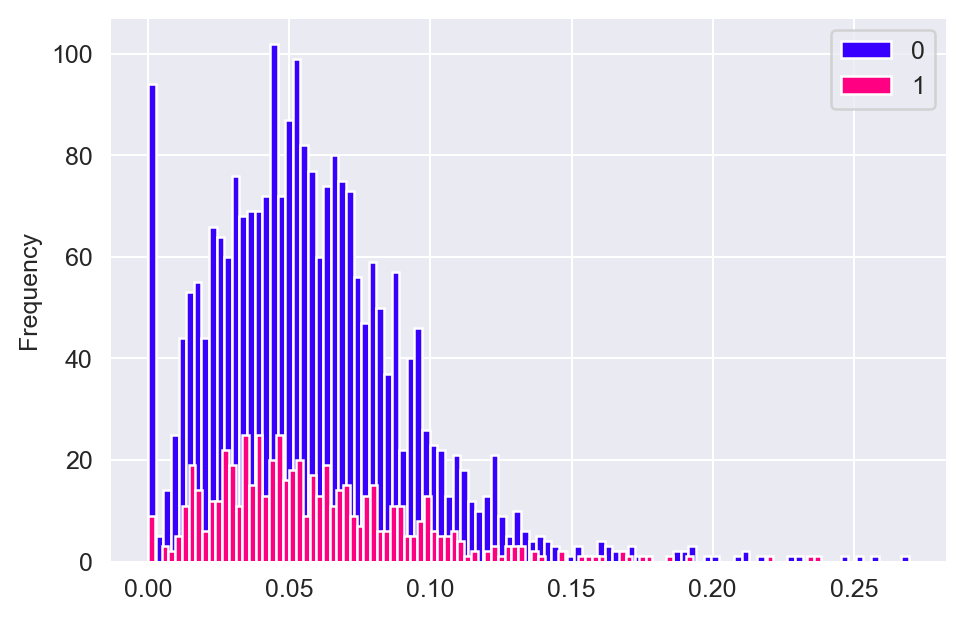

In [224]:
related_merged.groupby('agg_label')['dissimilarity_score'].plot(kind='hist', bins=100, legend=True)

In [237]:
from scipy.stats import mannwhitneyu, ttest_ind
for binder in ['Conserved', 'Improved']:
    for anchor in [True, False]:
        tmp = related_merged.query('binder==@binder and anchor_mutation==@anchor')
        pos = tmp.query('agg_label==1')['dissimilarity_score'].values
        neg = tmp.query('agg_label==0')['dissimilarity_score'].values
        print(f'{binder} Binder, {anchor} anchor; mwu:', mannwhitneyu(pos, neg)[1], 'ttest:', ttest_ind(pos,neg, equal_var=False)[1])


Conserved Binder, True anchor; mwu: 0.7790537289311881 ttest: 0.4772504658203883
Conserved Binder, False anchor; mwu: 0.9085927858226623 ttest: 0.47800041086296674
Improved Binder, True anchor; mwu: 0.5333253321097338 ttest: 0.9709978892787062
Improved Binder, False anchor; mwu: 0.7230117908272231 ttest: 0.7337449412403927


In [311]:
rest

Index(['Peptide', 'Peptide_mut', 'Peptide_wt', 'binder', 'core_mut', 'core_wt',
       'icore_mut', 'icore_wt', 'len', 'wild_type'],
      dtype='object')

In [320]:
pd.options.display.max_rows = 68
tmp = related_merged.query('agg_label==1 and anchor_mutation==False and binder=="Conserved" and ratio_rank>1 and EL_rank_wt>0.5 and EL_rank_mut <2')[subcols+['ratio_rank', 'binder','agg_label']]\
              .rename(columns = {'trueHLA_EL_rank':'old_EL_rank_mut',
                                 'wt_EL_rank':'old_EL_rank_wt',
                                 'ratio_rank':'ratio_rank_new'})
tmp['ratio_rank_old']=tmp['old_EL_rank_wt']/tmp['old_EL_rank_mut']
rank_cols = [x for x in tmp.columns if 'rank' in x.lower()]
rest = [x for x in tmp.columns.difference(rank_cols)]
tmp[rest+rank_cols].to_csv('../../Positive_problematic_conserved_binders_sample.csv', index=False)
tmp[rest+rank_cols]

,Peptide,Peptide_mut,Peptide_wt,agg_label,binder,core_mut,core_wt,icore_mut,icore_wt,len,wild_type,old_EL_rank_mut,old_EL_rank_wt,EL_rank_mut,EL_rank_wt,ratio_rank_new,ratio_rank_old
28,AGQHIAKSLF,GQHIAKSLF,GQHIAKSPF,1,Conserved,GQHIAKSLF,GQHIAKSPF,GQHIAKSLF,GQHIAKSPF,10,AGQHIAKSPF,4.1901,8.3134,1.9036,3.4639,1.819657,1.984058
47,ALALAQKGV,ALALAQKGV,ALALARKGV,1,Conserved,ALALAQKGV,ALALARKGV,ALALAQKGV,ALALARKGV,9,ALALARKGV,1.0758,2.9565,1.0758,2.9565,2.748187,2.748187
241,AVYHEIHIGYL,AVYHEIHIGYL,AVYHEILIGYL,1,Conserved,AVYHEIHYL,AVYHEILYL,AVYHEIHIGYL,AVYHEILIGYL,11,AVYHEILIGYL,1.0179,2.8968,1.0179,2.8968,2.845859,2.845859
259,CISNVFMQR,CISNVFMQR,CISNVFVQR,1,Conserved,CISNVFMQR,CISNVFVQR,CISNVFMQR,CISNVFVQR,9,CISNVFVQR,1.1846,1.5064,1.1846,1.5064,1.271653,1.271653
290,CTIAVVNFL,CTIAVVNFL,CTNAVVNFL,1,Conserved,CTIAVVNFL,CTNAVVNFL,CTIAVVNFL,CTNAVVNFL,9,CTNAVVNFL,0.3917,0.5903,0.3917,0.5903,1.507021,1.507021
404,FAIADTAYV,FAIADTAYV,FASADTAYV,1,Conserved,FAIADTAYV,FASADTAYV,FAIADTAYV,FASADTAYV,9,FASADTAYV,0.5549,0.9583,0.5549,0.9583,1.726978,1.726978
441,FIDCYLLAI,FIDCYLLAI,SIDCYLLAI,1,Conserved,FIDCYLLAI,SIDCYLLAI,FIDCYLLAI,SIDCYLLAI,9,SIDCYLLAI,1.2411,2.6848,1.2411,2.6848,2.163242,2.163242
452,FILLLFLTIFI,LLLFLTIFI,LLLFLAIFI,1,Conserved,LLLFLTIFI,LLLFLAIFI,LLLFLTIFI,LLLFLAIFI,11,FILLLFLAIFI,8.3597,11.9984,1.7142,2.9379,1.713861,1.435267
511,FLLRFLYTQL,FLLRFLYTQL,SLLRFLYTQL,1,Conserved,FLLRFLTQL,SLLRFLTQL,FLLRFLYTQL,SLLRFLYTQL,10,SLLRFLYTQL,1.0265,1.1243,1.0265,1.1243,1.095275,1.095275
544,FLTAHSLPL,FLTAHSLPL,FLTAHRLPL,1,Conserved,FLTAHSLPL,FLTAHRLPL,FLTAHSLPL,FLTAHRLPL,9,FLTAHRLPL,0.2692,0.9401,0.2692,0.9401,3.492199,3.492199


In [271]:
related_merged.groupby(['anchor_mutation', 'binder', 'agg_label']).agg(count=('Peptide','count'))

count
anchor_mutation binder    agg_label       
False           Conserved 0           1465
                          1            364
                Improved  0             89
                          1             18
True            Conserved 0            570
                          1            106
                Improved  0            317
                          1            104

In [288]:
related_merged.loc[related_merged.apply(lambda x: len(x['Peptide_mut'])!= len(x['Peptide_wt']), axis=1)][subcols+['anchor_mutation','binder', 'agg_label']]

,Peptide,wild_type,trueHLA_EL_rank,wt_EL_rank,EL_rank_mut,EL_rank_wt,len,Peptide_mut,Peptide_wt,core_mut,core_wt,icore_mut,icore_wt,anchor_mutation,binder,agg_label
8,AAPAHSHAV,AAPAHSHAG,0.8023,42.1176,0.8023,35.6875,9,AAPAHSHAV,AAPAHSHA,AAPAHSHAV,AAP-AHSHA,AAPAHSHAV,AAPAHSHA,True,Improved,0
31,AILLGAEEK,AKLLGAEEK,0.3346,7.5168,0.3346,5.9022,9,AILLGAEEK,KLLGAEEK,AILLGAEEK,KLL-GAEEK,AILLGAEEK,KLLGAEEK,True,Improved,0
33,AILPFTPEFL,AISPFTPEFL,0.7790,1.4141,0.5632,1.4141,10,ILPFTPEFL,AISPFTPEFL,ILPFTPEFL,AISPFTPEL,ILPFTPEFL,AISPFTPEFL,True,Conserved,0
34,AILPFTPEFLV,AISPFTPEFLV,0.6360,1.0875,0.5632,1.0875,11,ILPFTPEFL,AISPFTPEFLV,ILPFTPEFL,AISPFTPEV,ILPFTPEFL,AISPFTPEFLV,True,Conserved,0
39,AIYHTLNLFNI,AIYHTLNLCNI,5.8573,7.5550,4.7939,3.4539,11,AIYHTLNL,AIYHTLNLC,AIY-HTLNL,AIYHTLNLC,AIYHTLNL,AIYHTLNLC,True,Conserved,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2984,YSWSAQRQAL,YSWSAQRRAL,1.9060,1.8906,0.8898,0.9112,10,YSWSAQRQA,WSAQRRAL,YSWSAQRQA,WSA-QRRAL,YSWSAQRQA,WSAQRRAL,True,Conserved,0
2986,YTAPGIVEI,DTAPGIVEI,0.0533,2.4396,0.0533,2.0632,9,YTAPGIVEI,TAPGIVEI,YTAPGIVEI,TA-PGIVEI,YTAPGIVEI,TAPGIVEI,False,Improved,0
2998,YTLSQCFQL,CTLSQCFQL,0.9252,7.6774,0.9252,4.3204,9,YTLSQCFQL,TLSQCFQL,YTLSQCFQL,TL-SQCFQL,YTLSQCFQL,TLSQCFQL,False,Improved,0
3013,YVMASVFVCPL,YVMASVFVCLL,3.6690,3.3129,3.0785,0.5738,11,YVMASVFV,VMASVFVCL,YVMASVF-V,VMASVFVCL,YVMASVFV,VMASVFVCL,True,Conserved,0


## Mutscores

In [596]:
related_merged['mutation_score'] = related_merged.apply(lambda x: get_mutation_score(x['mutation_position'], x['Peptide'], x['wild_type']), axis=1)
related_merged['blsm_mut_score'] = related_merged.apply(lambda x: get_blsm_mutation_score(x['mutation_position'], x['Peptide'], x['wild_type']), axis=1)

related_merged['core_mutation_score'] = related_merged.apply(lambda x: get_mutation_score(x['core_mutation_position'], x['core_mut'], x['core_wt']), axis=1)
related_merged['core_blsm_mut_score'] = related_merged.apply(lambda x: get_blsm_mutation_score(x['core_mutation_position'], x['core_mut'], x['core_wt']), axis=1)

In [599]:
pd.options.display.max_rows = 20
related_merged.groupby('agg_label')['dissimilarity_score', 'mutation_score', 'blsm_mut_score', 'core_mutation_score',
                                    'core_blsm_mut_score']\
              .quantile(q=np.arange(0.1,1.1,0.1)).rename(columns = {k:f'Quantile {k:.0%}' for k in np.arange(0.1,1.1,0.1)})

dissimilarity_score  mutation_score  blsm_mut_score  \
agg_label                                                            
0         0.1             0.016584             2.0            -3.0   
          0.2             0.028597             2.0            -2.0   
          0.3             0.037356             2.0            -2.0   
          0.4             0.045687             2.0            -2.0   
          0.5             0.053460             2.0            -1.0   
          0.6             0.062170             4.0             0.0   
          0.7             0.071296             4.0             0.0   
          0.8             0.082198             4.0             1.0   
          0.9             0.099304             4.0             1.0   
          1.0             0.269576            10.0             4.0   
1         0.1             0.018982             2.0            -3.0   
          0.2             0.029031             2.0            -3.0   
          0.3             0.037150             2.0            -2.0   
          0.4             0.044384             2.0            -2.0   
          0.5             0.051025             2.0            -1.0   
          0.6             0.061124             3.0            -1.0   
          0.7             0.070538             4.0             0.0   
          0.8             0.084358             4.0             1.0   
          0.9             0.101186             4.0             1.0   
          1.0             0.238194            12.0             5.0   

               core_mutation_score  core_blsm_mut_score  
agg_label                                                
0         0.1                  0.0                 -6.0  
          0.2                  2.0                 -3.0  
          0.3                  2.0                 -2.0  
          0.4                  2.0                 -2.0  
          0.5                  2.0                 -1.0  
          0.6                  4.0                  0.0  
          0.7                  4.0                  0.0  
          0.8                  4.0                  1.0  
          0.9                  6.0                  2.0  
          1.0                 28.0                  9.0  
1         0.1                  1.0                 -4.0  
          0.2                  2.0                 -3.0  
          0.3                  2.0                 -2.0  
          0.4                  2.0                 -2.0  
          0.5                  2.0                 -1.0  
          0.6                  4.0                 -1.0  
          0.7                  4.0                  0.0  
          0.8                  4.0                  1.0  
          0.9                  6.0                  2.0  
          1.0                 24.0                  6.0

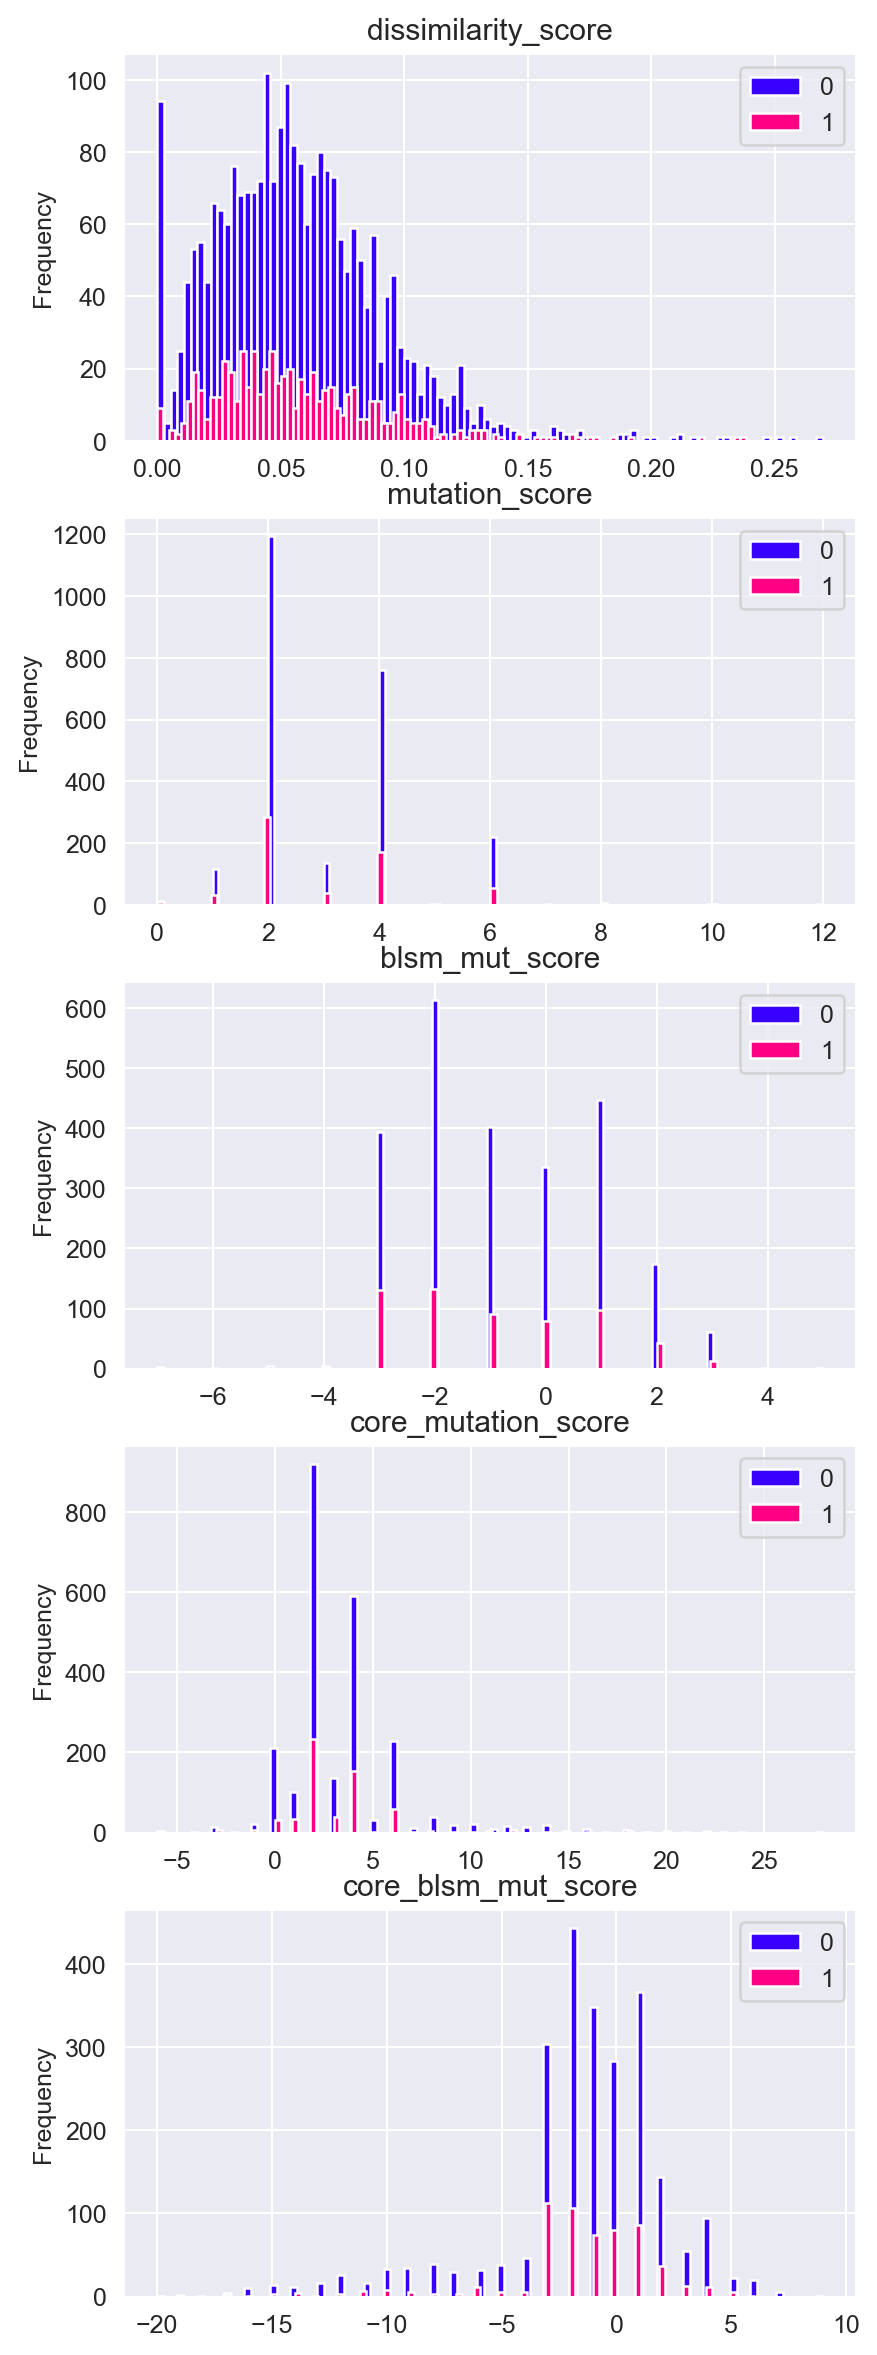

In [601]:
f,a = plt.subplots(5,1, figsize=(5.25, 16.5))
for i, col in enumerate(['dissimilarity_score', 'mutation_score', 'blsm_mut_score', 
                         'core_mutation_score', 'core_blsm_mut_score']):
    related_merged.groupby('agg_label')[col]\
                  .plot(kind='hist', bins=100, legend=True, ax=a[i])
    a[i].set_title(col)

### Mutscores

In [252]:
related_merged['mutation_score'] = related_merged.apply(lambda x: get_mutation_score(x['mutation_position'], x['Peptide'], x['wild_type']), axis=1)
related_merged['blsm_mut_score'] = related_merged.apply(lambda x: get_mutation_score(x['mutation_position'], x['Peptide'], x['wild_type']), axis=1)

related_merged['core_mutation_score'] = related_merged.apply(lambda x: get_mutation_score(x['core_mutation_position'], x['core_mut'], x['core_wt']), axis=1)
related_merged['core_blsm_mut_score'] = related_merged.apply(lambda x: get_mutation_score(x['core_mutation_position'], x['core_mut'], x['core_wt']), axis=1)


In [265]:
related_merged.groupby('agg_label')[['dissimilarity_score','mutation_score', 'blsm_mut_score', 'core_mutation_score', 'core_blsm_mut_score']]\
              .quantile(q=np.linspace(0.1,1.0,10)).rename(columns={k:f'Quantile {k:.0%}' for k in np.linspace(0.1,1.0,10)})

dissimilarity_score  mutation_score  blsm_mut_score  \
agg_label                                                            
0         0.1             0.016584        0.693147        0.693147   
          0.2             0.028597        0.693147        0.693147   
          0.3             0.037356        0.693147        0.693147   
          0.4             0.045687        0.693147        0.693147   
          0.5             0.053460        0.693147        0.693147   
          0.6             0.062170        1.386294        1.386294   
          0.7             0.071296        1.386294        1.386294   
          0.8             0.082198        1.386294        1.386294   
          0.9             0.099304        1.386294        1.386294   
          1.0             0.269576        2.302585        2.302585   
1         0.1             0.018982        0.693147        0.693147   
          0.2             0.029031        0.693147        0.693147   
          0.3             0.037150        0.693147        0.693147   
          0.4             0.044384        0.693147        0.693147   
          0.5             0.051025        0.693147        0.693147   
          0.6             0.061124        1.098612        1.098612   
          0.7             0.070538        1.386294        1.386294   
          0.8             0.084358        1.386294        1.386294   
          0.9             0.101186        1.386294        1.386294   
          1.0             0.238194        2.484907        2.484907   

               core_mutation_score  core_blsm_mut_score  
agg_label                                                
0         0.1             0.693147             0.693147  
          0.2             0.693147             0.693147  
          0.3             0.693147             0.693147  
          0.4             0.693147             0.693147  
          0.5             1.098612             1.098612  
          0.6             1.386294             1.386294  
          0.7             1.386294             1.386294  
          0.8             1.386294             1.386294  
          0.9             1.791759             1.791759  
          1.0             3.332205             3.332205  
1         0.1             0.693147             0.693147  
          0.2             0.693147             0.693147  
          0.3             0.693147             0.693147  
          0.4             0.693147             0.693147  
          0.5             0.693147             0.693147  
          0.6             1.386294             1.386294  
          0.7             1.386294             1.386294  
          0.8             1.386294             1.386294  
          0.9             1.791759             1.791759  
          1.0             3.178054             3.178054

agg_label
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: core_blsm_mut_score, dtype: object

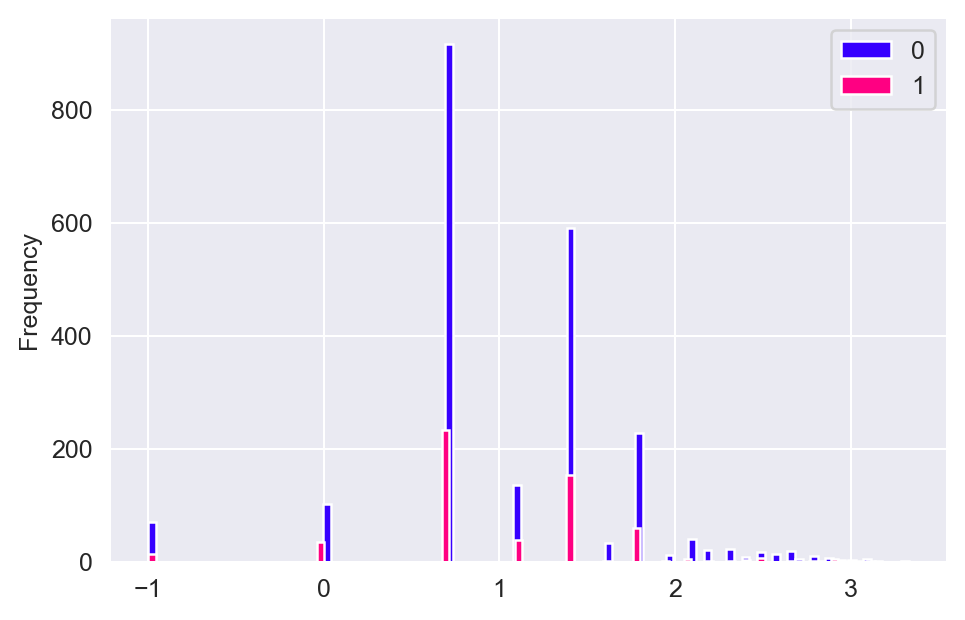

In [253]:
related_merged.groupby(['agg_label'])['core_blsm_mut_score'].plot(kind='hist', bins=100, legend=True)

## Making folds

In [322]:
related_merged.drop(columns = ['lencore', 'len_1', 'len_2'], inplace=True)
related_merged['len_icore_mut'] = related_merged['icore_mut'].apply(len)
related_merged['len_icore_wt'] = related_merged['icore_wt'].apply(len)
related_merged['len_pep_mut'] = related_merged['Peptide_mut'].apply(len)
related_merged['len_pep_wt'] = related_merged['Peptide_wt'].apply(len)

In [338]:
(related_merged['icore_mut']==related_merged['Peptide_mut']).all()

True

In [333]:
display(related_merged.groupby(['len_pep_mut']).agg(count=('Peptide', 'count')))
display(related_merged.groupby(['len']).agg(count=('Peptide', 'count')))

,count
len_pep_mut,
8,125
9,2146
10,525
11,236
12,1


,count
len,
9,1531
10,875
11,625
12,2


In [335]:
related_merged.drop(columns=[x for x in related_merged.columns if 'delta' in x], inplace=True)

In [370]:
# Icore mut yields duplicates due to duplicated cores for distinct peptides
related_merged['icore_mut'].to_csv('../../../kern_dist/data/221028_related_icore_mut.pep', index=False, header=False)
related_merged['Peptide'].to_csv('../../../kern_dist/data/221028_Peptide_mut.pep', index=False, header=False)

In [535]:
from src.partition_tools import pipeline_stratified_kfold
related_merged_fold = pipeline_stratified_kfold('../../../kern_dist/out/221028_Peptide_mut.pep_0.8.out', 
                                                related_merged.reset_index(drop=True),
                                               k=10, shuffle=True, seed=20, pep_col = 'Peptide', elrank_col = 'EL_rank_mut')

# related_merged_core_fold = pipeline_stratified_kfold('../../../kern_dist/out/221028_related_icore_mut.pep_0.8.out', 
#                                                 related_merged.reset_index(drop=True),
#                                                k=10, shuffle=True, seed=20, pep_col = 'icore_mut', elrank_col = 'EL_rank_mut')


In [536]:
pd.options.display.max_rows=678
diff=related_merged_fold.loc[related_merged_fold.duplicated(['icore_mut', 'HLA'], keep=False)][['HLA', 'Peptide', 'Peptide_mut','EL_rank_mut', 'core_mut', 'icore_mut','agg_label']]\
                   .groupby(['HLA', 'icore_mut']).agg(diff=('agg_label','std')).query('diff!=0').reset_index()
diff_labels = related_merged_fold.query('icore_mut in @diff.icore_mut.values').sort_values('icore_mut')[['HLA', 'Peptide','Peptide_mut', 'icore_mut', 'core_mut', 'EL_rank_mut', 'agg_label','fold']]
print(len(diff_labels.icore_mut.unique()), len(diff_labels))
diff_labels.head(10)

30 75


,HLA,Peptide,Peptide_mut,icore_mut,core_mut,EL_rank_mut,agg_label,fold
62,HLA-A0201,ALDPHSGHFV,ALDPHSGHFV,ALDPHSGHFV,ALDPHSHFV,0.0854,1,8
63,HLA-A0201,ALDPHSGHFVA,ALDPHSGHFV,ALDPHSGHFV,ALDPHSHFV,0.0854,0,8
1101,HLA-A0201,KALDPHSGHFV,ALDPHSGHFV,ALDPHSGHFV,ALDPHSHFV,0.0854,0,8
6,HLA-A0201,AALLQVTLLL,ALLQVTLLL,ALLQVTLLL,ALLQVTLLL,0.0995,0,6
90,HLA-A0201,ALLQVTLLL,ALLQVTLLL,ALLQVTLLL,ALLQVTLLL,0.0995,1,6
121,HLA-A0201,AMAGSLVFL,AMAGSLVFL,AMAGSLVFL,AMAGSLVFL,0.0845,1,6
123,HLA-B0702,AMAGSLVFL,AMAGSLVFL,AMAGSLVFL,AMAGSLVFL,6.2205,0,6
125,HLA-A2402,AMAGSLVFL,AMAGSLVFL,AMAGSLVFL,AMAGSLVFL,4.1874,0,6
1364,HLA-A0201,LAMAGSLVFL,AMAGSLVFL,AMAGSLVFL,AMAGSLVFL,0.0845,0,2
726,HLA-A0201,GLAMAGSLVFL,AMAGSLVFL,AMAGSLVFL,AMAGSLVFL,0.0845,0,2


In [537]:
from src.data_processing import get_aa_properties
related_fold_aaprops, aa_cols = get_aa_properties(related_merged_fold, seq_col='Peptide') 

## Collapsing datapoints with same icores and re-defining neg-pos

In [538]:
prop_same_core = len(related_fold_aaprops.query('agg_label==1 and core_mut==core_wt'))/len(related_fold_aaprops.query('agg_label==0 and core_mut==core_wt'))
prop_diff_core = len(related_fold_aaprops.query('agg_label==1 and core_mut!=core_wt'))/len(related_fold_aaprops.query('agg_label==0 and core_mut!=core_wt'))
prop_overall = len(related_fold_aaprops.query('agg_label==1'))/len(related_fold_aaprops.query('agg_label==0'))
print('BEFORE collapsing data')
print(f'pos/neg prop with same core:\t{prop_same_core}\npos/neg prop with diff core:\t{prop_diff_core}\npos/neg prop overall:\t\t{prop_overall}')

BEFORE collapsing data
pos/neg prop with same core:	0.1276595744680851
pos/neg prop with diff core:	0.24956521739130436
pos/neg prop overall:		0.24252355591970504


In [539]:
def most_common(x):
    return np.bincount(x).argmax()

In [540]:
fucking_gb = diff_labels.groupby(['icore_mut', 'HLA']).agg(max_label=('agg_label','max'), top_fold = ('fold', most_common))
fucking_folds = fucking_gb.reset_index().groupby(['icore_mut']).agg(top_fold=('top_fold', most_common))
for i, row in fucking_gb.iterrows():
    core = row.name[0]    
    hla = row.name[1]
    indices = related_fold_aaprops.query('HLA==@hla and icore_mut == @core').index
    related_fold_aaprops.loc[indices, 'agg_label']= row['max_label']
    related_fold_aaprops.loc[indices, 'fold'] = int(fucking_folds.loc[core].top_fold)

In [542]:
prop_same_core = len(related_fold_aaprops.query('agg_label==1 and core_mut==core_wt'))/len(related_fold_aaprops.query('agg_label==0 and core_mut==core_wt'))
prop_diff_core = len(related_fold_aaprops.query('agg_label==1 and core_mut!=core_wt'))/len(related_fold_aaprops.query('agg_label==0 and core_mut!=core_wt'))
prop_overall = len(related_fold_aaprops.query('agg_label==1'))/len(related_fold_aaprops.query('agg_label==0'))
print('AFTER collapsing data')
print(f'pos/neg prop with same core:\t{prop_same_core}\npos/neg prop with diff core:\t{prop_diff_core}\npos/neg prop overall:\t\t{prop_overall}')

AFTER collapsing data
pos/neg prop with same core:	0.1276595744680851
pos/neg prop with diff core:	0.2711189739053516
pos/neg prop overall:		0.2626977518734388


In [544]:
related_fold_aaprops.query('core_mut==core_wt and agg_label==1')[subcols+['HLA']]

,Peptide,wild_type,trueHLA_EL_rank,wt_EL_rank,EL_rank_mut,EL_rank_wt,len,Peptide_mut,Peptide_wt,core_mut,core_wt,icore_mut,icore_wt,HLA
890,HQNPVTGLLL,HQNPVTGLLP,0.4505,8.3554,0.1582,0.1582,10,HQNPVTGLL,HQNPVTGLL,HQNPVTGLL,HQNPVTGLL,HQNPVTGLL,HQNPVTGLL,HLA-B3801
1028,IPDSIALIQQL,IPDSIAVIQQL,0.7846,0.7692,0.7846,0.7692,11,IPDSIALIQQL,IPDSIAVIQQL,IPDSIAQQL,IPDSIAQQL,IPDSIALIQQL,IPDSIAVIQQL,HLA-B0702
1220,KLVVVGACGV,KLVVVGAGGV,5.3829,6.0865,5.3829,6.0865,10,KLVVVGACGV,KLVVVGAGGV,KLVVVGAGV,KLVVVGAGV,KLVVVGACGV,KLVVVGAGGV,HLA-A0201
1221,KLVVVGADGV,KLVVVGAGGV,3.2976,3.2011,3.2976,3.2011,10,KLVVVGADGV,KLVVVGAGGV,KLVVVGAGV,KLVVVGAGV,KLVVVGADGV,KLVVVGAGGV,HLA-A0203
1251,KPKKENLWRM,KPKKENLRRM,0.4590,0.4129,0.4590,0.4129,10,KPKKENLWRM,KPKKENLRRM,KPKKENLRM,KPKKENLRM,KPKKENLWRM,KPKKENLRRM,HLA-B0702
1306,KTGEQRVVTL,ETGEQRVVTL,9.5707,17.3019,3.2579,3.2579,10,TGEQRVVTL,TGEQRVVTL,TGEQRVVTL,TGEQRVVTL,TGEQRVVTL,TGEQRVVTL,HLA-C1203
1524,LMLEYQKILWK,LMLKYQKILWK,5.1172,5.4139,2.3040,2.3837,11,MLEYQKILWK,MLKYQKILWK,MLYQKILWK,MLYQKILWK,MLEYQKILWK,MLKYQKILWK,HLA-A1101
1690,MLEYQKILWK,MLKYQKILWK,2.3040,2.3837,2.3040,2.3837,10,MLEYQKILWK,MLKYQKILWK,MLYQKILWK,MLYQKILWK,MLEYQKILWK,MLKYQKILWK,HLA-A1101
1691,MLEYQKILWKV,MLKYQKILWKV,2.9861,3.0418,2.1404,2.1404,11,YQKILWKV,YQKILWKV,YQ-KILWKV,YQ-KILWKV,YQKILWKV,YQKILWKV,HLA-A0201
1735,MQLMPFGCLL,TQLMPFGCLL,2.9729,3.0424,0.5522,0.5522,10,QLMPFGCLL,QLMPFGCLL,QLMPFGCLL,QLMPFGCLL,QLMPFGCLL,QLMPFGCLL,HLA-A0201


## Hyperparameters check

In [ ]:
dir_='../output/tuning/rf_bootstrap/'
df = pd.DataFrame()
for x in [x for x in os.listdir(dir_) if 'onehot' in x.lower()]:
    df= df.append(pd.DataFrame(pkl_load(os.path.join(dir_,x)), index=[0]))
df.reset_index(drop=True)

In [193]:
import itertools
df['learning_rate']=1
df['max_depth'].replace(np.nan, -1,inplace=True)
cols_ = ['ccp_alpha', 'max_depth', 'n_estimators']
mcs = []
for L in range(1, len(cols_)+1):
    for mc in itertools.combinations(cols_, L):
        mcs.append(list(mc))
for mc in mcs:
    display(df.groupby(mc).count())


,max_depth,n_estimators,learning_rate,reg_alpha,reg_lambda
ccp_alpha,,,,,
1.000000e-09,43,43,43,0,0
4.641589e-07,62,62,62,0,0
2.154435e-04,67,67,67,0,0


,ccp_alpha,n_estimators,learning_rate,reg_alpha,reg_lambda
max_depth,,,,,
-1.0,68,71,71,3,3
3.0,2,11,11,9,9
5.0,5,5,5,0,0
7.0,50,54,54,4,4
9.0,47,47,47,0,0


,ccp_alpha,max_depth,learning_rate,reg_alpha,reg_lambda
n_estimators,,,,,
100.0,17,17,17,0,0
200.0,46,59,59,13,13
250.0,25,28,28,3,3
300.0,84,84,84,0,0


n_estimators  learning_rate  reg_alpha  reg_lambda
ccp_alpha    max_depth                                                    
1.000000e-09 -1.0                 18             18          0           0
              5.0                  1              1          0           0
              7.0                 12             12          0           0
              9.0                 12             12          0           0
4.641589e-07 -1.0                 27             27          0           0
              5.0                  4              4          0           0
              7.0                 15             15          0           0
              9.0                 16             16          0           0
2.154435e-04 -1.0                 23             23          0           0
              3.0                  2              2          0           0
              7.0                 23             23          0           0
              9.0                 19             19          0           0

max_depth  learning_rate  reg_alpha  reg_lambda
ccp_alpha    n_estimators                                                 
1.000000e-09 100.0                 3              3          0           0
             200.0                10             10          0           0
             250.0                 6              6          0           0
             300.0                24             24          0           0
4.641589e-07 100.0                 5              5          0           0
             200.0                18             18          0           0
             250.0                 9              9          0           0
             300.0                30             30          0           0
2.154435e-04 100.0                 9              9          0           0
             200.0                18             18          0           0
             250.0                10             10          0           0
             300.0                30             30          0           0

ccp_alpha  learning_rate  reg_alpha  reg_lambda
max_depth n_estimators                                                 
-1.0      100.0                 4              4          0           0
          200.0                14             16          2           2
          250.0                17             18          1           1
          300.0                33             33          0           0
 3.0      200.0                 1              9          8           8
          250.0                 0              1          1           1
          300.0                 1              1          0           0
 5.0      100.0                 1              1          0           0
          200.0                 3              3          0           0
          300.0                 1              1          0           0
 7.0      100.0                 5              5          0           0
          200.0                13             16          3           3
          250.0                 8              9          1           1
          300.0                24             24          0           0
 9.0      100.0                 7              7          0           0
          200.0                15             15          0           0
          300.0                25             25          0           0

learning_rate  reg_alpha  reg_lambda
ccp_alpha    max_depth n_estimators                                      
1.000000e-09 -1.0      100.0                     1          0           0
                       200.0                     2          0           0
                       250.0                     3          0           0
                       300.0                    12          0           0
              5.0      200.0                     1          0           0
              7.0      100.0                     2          0           0
                       200.0                     3          0           0
                       250.0                     3          0           0
                       300.0                     4          0           0
              9.0      200.0                     4          0           0
                       300.0                     8          0           0
4.641589e-07 -1.0      200.0                     8          0           0
                       250.0                     7          0           0
                       300.0                    12          0           0
              5.0      100.0                     1          0           0
                       200.0                     2          0           0
                       300.0                     1          0           0
              7.0      100.0                     1          0           0
                       200.0                     5          0           0
                       250.0                     2          0           0
                       300.0                     7          0           0
              9.0      100.0                     3          0           0
                       200.0                     3          0           0
                       300.0                    10          0           0
2.154435e-04 -1.0      100.0                     3          0           0
                       200.0                     4          0           0
                       250.0                     7          0           0
                       300.0                     9          0           0
              3.0      200.0                     1          0           0
                       300.0                     1          0           0
              7.0      100.0                     2          0           0
                       200.0                     5          0           0
                       250.0                     3          0           0
                       300.0                    13          0           0
              9.0      100.0                     4          0           0
                       200.0                     8          0           0
                       300.0                     7          0           0

In [197]:
df.quantile(q=np.arange(0.1,1.1, 0.1))

,ccp_alpha,max_depth,n_estimators,learning_rate,reg_alpha,reg_lambda
0.1,1.000000e-09,-1.0,200.0,1.0,1.000000e-09,2.325794e-07
0.2,1.000000e-09,-1.0,200.0,1.0,1.000000e-09,2.154435e-04
0.3,4.641589e-07,-1.0,200.0,1.0,1.077222e-04,2.154435e-04
0.4,4.641589e-07,3.0,200.0,1.0,2.154435e-04,2.154435e-04
0.5,4.641589e-07,7.0,250.0,1.0,1.000000e-01,5.010772e-02
0.6,4.641589e-07,7.0,300.0,1.0,1.000000e-01,1.000000e-01
0.7,2.154435e-04,7.0,300.0,1.0,1.000000e-01,1.000000e-01
0.8,2.154435e-04,9.0,300.0,1.0,1.000000e-01,1.000000e-01
0.9,2.154435e-04,9.0,300.0,1.0,1.000000e-01,1.000000e-01
1.0,2.154435e-04,9.0,300.0,1.0,1.000000e-01,1.000000e-01


In [ ]:
# BOOTSTRAP FUNCTIONS
from joblib import Parallel, delayed
from functools import partial
from src.metrics import get_metrics


def bootstrap_wrapper(y_score, y_true, seed):    
    np.random.seed(seed)
    sample_idx = np.random.randint(0, len(y_score), len(y_score))
    sample_score = y_score[sample_idx]
    sample_true = y_true[sample_idx]
    
    try:
        test_results = get_metrics(sample_true, sample_score)
    except:
        return pd.DataFrame(), (None, None, None, None)
    
    # Save to get mean curves after
    roc_curve = (test_results.pop('roc_curve'), test_results['auc'])
    # Same
    pr_curve = (test_results.pop('pr_curve'), test_results['prauc'])
    return pd.DataFrame(test_results, index=[0]), roc_curve 


def bootstrap_eval(y_score, y_true, n_rounds=10000, n_jobs=16):
    wrapper = partial(bootstrap_wrapper, 
                      y_score=y_score, y_true=y_true)
    print('Sampling')
    output = Parallel(n_jobs=n_jobs)(delayed(wrapper)(seed=seed) for seed in tqdm(range(n_rounds), desc='Bootstrapping rounds', position=1, leave=False))
    
    print('Making results DF and curves')
    result_df = pd.concat([x[0] for x in output])
    mean_roc_curve = get_mean_roc_curve([x[1] for x in output if x[1][0] is not None])
    # mean_pr_curve = get_mean_pr_curve([x[2] for x in output])
    return result_df, mean_roc_curve

def load_hyperparams(encoding_kwargs, train_dataset, MAPPING, model, blosum_matrix=None, weight = None):
    outdict = {'trainset': train_dataset['trainset'].unique()[0],
                       'model': MAPPING[model.__class__.__name__],
                       'weight': weight} # Hardcoded here
        
    outdict.update({k: v for k, v in encoding_kwargs.items() if k != 'blosum_matrix'})
    
    if blosum_matrix is not None:
        bl_name = 'BL62LO' if blosum_matrix['A'].dtype == np.int64 else 'BL62FREQ'
        outdict['blsm'] = bl_name
    cols_keys = [x for x in outdict.keys() if '_col' in x]
    for k in cols_keys:
        del outdict[k]
    outname = '_'.join([f'{k}{v}' for k, v in outdict.items() if k!='invert'])
        
    pkl_name = convert_path(os.path.join(f'../output/tuning/{MAPPING[model.__class__.__name__].lower()}_bootstrap', (outname + '.pkl')).replace('//', '/'))
    hyperparams = pkl_load(pkl_name)
    if 'max_depth' in hyperparams:
        if np.isnan(hyperparams['max_depth']):
            hyperparams['max_depth'] = None
        else:
    
            hyperparams['max_depth'] = int(hyperparams['max_depth'])
    
    for k in [x for x in hyperparams.keys() if x.startswith('n_')]:
        # converts n_estimators, n_layers, n_in, n_hidden, to int
        hyperparams[k] = int(hyperparams[k])
    return hyperparams

In [646]:
related_fold_aaprops.to_csv('../data/mutant/221028_related_newcore_fold.csv', index=False)

In [ ]:
from src.data_processing import get_mutation_dataset
from src.metrics import get_metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from copy import deepcopy

def assert_encoding_kwargs(encoding_kwargs, mode_eval=False):
    """
    Assertion / checks for encoding kwargs and verify all the necessary key-values 
    are in
    """
    # Making a deep copy since dicts are mutable between fct calls
    encoding_kwargs = deepcopy(encoding_kwargs)
    if encoding_kwargs is None:
        encoding_kwargs = {'max_len': 12,
                           'encoding': 'onehot',
                           'blosum_matrix': None,
                           'standardize': False}
    essential_keys = ['max_len', 'encoding', 'blosum_matrix', 'standardize']
    assert all([x in encoding_kwargs.keys() for x in
                essential_keys]), f'Encoding kwargs don\'t contain the essential key-value pairs! ' \
                                  f"{'max_len', 'encoding', 'blosum_matrix', 'standardize'} are required."

    if mode_eval:
        if any([(x not in encoding_kwargs.keys()) for x in ['seq_col', 'hla_col', 'target_col', 'rank_col']]):
            encoding_kwargs.update({'seq_col': 'Peptide',
                                    'hla_col': 'HLA',
                                    'target_col': 'agg_label',
                                    'rank_col': 'trueHLA_EL_rank'})

        # This KWARGS not needed in eval mode since I'm using Pipeline and Wrapper
        del encoding_kwargs['standardize']
    return encoding_kwargs


def get_predictions(df, models, ics_dict, encoding_kwargs):
    """
    Args:
        models (list) : list of all the models for a given fold. Should be a LIST
        ics_dict (dict): weights or None
        encoding_kwargs: the kwargs needed to process the df
        metrics (dict):

    Returns:
        predictions_df (pd
        df (pd.DataFrame): DataFrame containing the Peptide-HLA pairs to evaluate
        models (list): A.DataFrame): Original DataFrame + a column predictions which are the scores + y_true
    """

    df = df.copy()

    # HERE NEED TO DO SWITCH CASES
    x, y = get_mutation_dataset(df, ics_dict, **encoding_kwargs)

    # Take the first model in the list and get its class
    model_class = models[0].__class__

    # If model is a scikit-learn model, get pred prob
    if issubclass(model_class, sklearn.base.BaseEstimator):
        average_predictions = [model.predict_proba(x)[:, 1] \
                               for model in models]
    # If models list is a torch model, use forward
    elif issubclass(model_class, nn.Module):
        x = torch.from_numpy(x)
        with torch.no_grad():
            average_predictions = [model(x).detach().cpu().numpy() for model in models]

    average_predictions = np.mean(np.stack(average_predictions), axis=0)
    # assert len(average_predictions)==len(df), f'Wrong shapes passed preds:{len(average_predictions)},df:{len(df)}'
    output_df = df.copy(deep=True)
    output_df['pred'] = average_predictions
    return output_df


# TRAIN WITH PARALLEL WRAPPER
def parallel_inner_train_wrapper(train_dataframe, x_test, base_model, ics_dict,
                                 encoding_kwargs, standardize, fold_out, fold_in):
    seed = fold_out * 10 + fold_in
    # Copy the base model, resets the seed
    model = sklearn.base.clone(base_model)
    model.set_params(random_state=seed)
    if standardize:
        model = Pipeline([('scaler', StandardScaler()), ('model', model)])

    # Here resets model weight at every fold, using the fold number (range(0, n_folds*(n_folds-1)) ) as seed
    # Query subset dataframe and get encoded data and targets
    train = train_dataframe.query('fold != @fold_out and fold != @fold_in').reset_index(drop=True)
    valid = train_dataframe.query('fold == @fold_in').reset_index(drop=True)
    # Get datasets
    x_train, y_train = get_mutation_dataset(train, ics_dict, **encoding_kwargs)
    x_valid, y_valid = get_mutation_dataset(valid, ics_dict, **encoding_kwargs)

    # Fit the model and append it to the list
    model.fit(x_train, y_train)

    # Get the prediction values on both the train and validation set
    y_train_pred, y_train_score = model.predict(x_train), model.predict_proba(x_train)[:, 1]
    y_val_pred, y_val_score = model.predict(x_valid), model.predict_proba(x_valid)[:, 1]
    # Get the metrics and save them
    train_metrics = get_metrics(y_train, y_train_score, y_train_pred)
    valid_metrics = get_metrics(y_valid, y_val_score, y_val_pred)
    y_pred_test = model.predict_proba(x_test)[:, 1]

    return model, train_metrics, valid_metrics, y_pred_test


def nested_kcv_train_mut(dataframe, base_model, ics_dict, encoding_kwargs: dict = None, n_jobs=None):
    """
    Args:
        dataframe:
        base_model:
        ics_dict:
        encoding_kwargs:

    Returns:
        models_fold
        train_results
        test_results
    """
    encoding_kwargs = assert_encoding_kwargs(encoding_kwargs, mode_eval=False)
    #
    models_dict = {}
    test_metrics = {}
    train_metrics = {}
    folds = sorted(dataframe.fold.unique())
    std = encoding_kwargs.pop('standardize')
    for fold_out in tqdm(folds, leave=False, desc='Outer fold', position=2):
        # Get test set & init models list to house all models trained in inner fold
        test = dataframe.query('fold == @fold_out').reset_index(drop=True)
        x_test, y_test = get_mutation_dataset(test, ics_dict, **encoding_kwargs)
        # For a given fold, all the models that are trained should be appended to this list
        inner_folds = sorted([f for f in folds if f != fold_out])
        n_jobs = len(inner_folds) if n_jobs is None else n_jobs
        # Create the sub-dict and put the model into the models dict
        train_wrapper_ = partial(parallel_inner_train_wrapper, train_dataframe=dataframe, x_test=x_test,
                                 base_model=base_model, ics_dict=ics_dict, encoding_kwargs=encoding_kwargs,
                                 standardize=std, fold_out=fold_out)
        output = Parallel(n_jobs=n_jobs)(
            delayed(train_wrapper_)(fold_in=fold_in) for fold_in in tqdm(inner_folds,
                                                                         desc='Inner Folds',
                                                                         leave=False, position=1))
        models_dict[fold_out] = [x[0] for x in output]
        train_tmp = [x[1] for x in output]
        valid_tmp = [x[2] for x in output]
        avg_prediction = [x[3] for x in output]
        avg_prediction = np.mean(np.stack(avg_prediction), axis=0)
        train_metrics[fold_out] = {k: {'train': v_train,
                                       'valid': v_valid} for k, v_train, v_valid in
                                   zip(inner_folds, train_tmp, valid_tmp)}
        test_metrics[fold_out] = get_metrics(y_test, avg_prediction)

    return models_dict, train_metrics, test_metrics


# EVAL WITH PARALLEL WRAPPER
def parallel_eval_wrapper(test_dataframe, models_list, ics_dict,
                          train_dataframe, encoding_kwargs, fold_out):
    # If no train dataframe provided and test_dataframe is partitioned,
    # It will eval on each of the folds
    if 'fold' in test_dataframe.columns and test_dataframe.equals(train_dataframe):
        test_df = test_dataframe.query('fold==@fold_out')
    else:
        test_df = test_dataframe.copy().reset_index(drop=True)

    if train_dataframe is not None and not train_dataframe.equals(test_dataframe):
        tmp = train_dataframe.query('fold != @fold_out')
        train_peps = tmp[encoding_kwargs['seq_col']].unique()
        test_df = test_df.query(f'{encoding_kwargs["seq_col"]} not in @train_peps')

    predictions_df = get_predictions(test_df, models_list, ics_dict, encoding_kwargs)
    test_metrics = get_metrics(predictions_df[encoding_kwargs['target_col']].values,
                               predictions_df['pred'].values)
    return predictions_df, test_metrics


def evaluate_trained_models_mut(test_dataframe, models_dict, ics_dict,
                                    train_dataframe=None,
                                    encoding_kwargs: dict = None,
                                    concatenated=False, only_concat=False):
    """

    Args:
        dataframe:
        models_dict:
        ics_dict:
        train_metrics (dict): Should be used if standardize in encoding_kwargs is True...
        encoding_kwargs:
        concatenated:
        only_concat:

    Returns:
        test_results
        predictions_df
    """
    encoding_kwargs = assert_encoding_kwargs(encoding_kwargs, mode_eval=True)
    # Wrapper and parallel evaluation
    eval_wrapper_ = partial(parallel_eval_wrapper, test_dataframe=test_dataframe, ics_dict=ics_dict,
                            train_dataframe=train_dataframe, encoding_kwargs=encoding_kwargs)

    output = Parallel(n_jobs=8)(delayed(eval_wrapper_)(fold_out=fold_out, models_list=models_list) \
                                                      for (fold_out, models_list) in tqdm(models_dict.items(),
                                                                                          desc='Eval Folds',
                                                                                          leave=False,
                                                                                          position=2))
    predictions_df = [x[0] for x in output]
    # print('here', len(predictions_df), len(predictions_df[0]))
    test_metrics = [x[1] for x in output]

    test_results = {k: v for k, v in zip(models_dict.keys(), test_metrics)}

    # Here simply concatenates it to get all the predictions from the folds
    predictions_df = pd.concat(predictions_df)

    # Here get the concat results
    if concatenated:
        test_results['concatenated'] = get_metrics(predictions_df[encoding_kwargs['target_col']].values,
                                                   predictions_df['pred'].values)
    # Either concatenated, or mean predictions
    else:
        # obj_cols = [x for x,y in zip(predictions_df.dtypes.index, predictions_df.dtypes.values) if y=='object']
        cols = [encoding_kwargs['seq_col'], encoding_kwargs['hla_col'], encoding_kwargs['target_col']]
        mean_preds = predictions_df.groupby(cols).agg(mean_pred=('pred', 'mean'))
        predictions_df = test_dataframe.merge(mean_preds, left_on=cols, right_on=cols, suffixes=[None, None])
    # print('there', len(predictions_df))

    if only_concat and concatenated:
        keys_del = [k for k in test_results if k != 'concatenated']
        for k in keys_del:
            del test_results[k]

    return test_results, predictions_df

# Train 

## runs

In [643]:
related_fold_aaprops.to_csv('../data/mutant/related_newcore_fold.csv', index=False)

In [613]:
mcs = []
cols_ = ['dissimilarity_score', 'blsm_mut_score', 'mutation_score', 'ratio_rank']
for L in range(0, len(cols_)+1):
    for mc in itertools.combinations(cols_, L):
        mcs.append(list(mc))

cols_ = ['dissimilarity_score', 'core_blsm_mut_score', 'core_mutation_score', 'ratio_rank']
for L in range(0, len(cols_)+1):
    for mc in itertools.combinations(cols_, L):
        mcs.append(list(mc))
mcs.append(aa_cols)
mcs = list(np.unique(mcs))
mcs

[[],
 ['aliphatic_index',
  'boman',
  'hydrophobicity',
  'isoelectric_point',
  'VHSE1',
  'VHSE3',
  'VHSE7',
  'VHSE8'],
 ['blsm_mut_score'],
 ['blsm_mut_score', 'mutation_score'],
 ['blsm_mut_score', 'mutation_score', 'ratio_rank'],
 ['blsm_mut_score', 'ratio_rank'],
 ['core_blsm_mut_score'],
 ['core_blsm_mut_score', 'core_mutation_score'],
 ['core_blsm_mut_score', 'core_mutation_score', 'ratio_rank'],
 ['core_blsm_mut_score', 'ratio_rank'],
 ['core_mutation_score'],
 ['core_mutation_score', 'ratio_rank'],
 ['dissimilarity_score'],
 ['dissimilarity_score', 'blsm_mut_score'],
 ['dissimilarity_score', 'blsm_mut_score', 'mutation_score'],
 ['dissimilarity_score', 'blsm_mut_score', 'mutation_score', 'ratio_rank'],
 ['dissimilarity_score', 'blsm_mut_score', 'ratio_rank'],
 ['dissimilarity_score', 'core_blsm_mut_score'],
 ['dissimilarity_score', 'core_blsm_mut_score', 'core_mutation_score'],
 ['dissimilarity_score',
  'core_blsm_mut_score',
  'core_mutation_score',
  'ratio_rank'],
 ['d

In [605]:
# Prints to terminal instead of nb
import sys
nb_stdout = sys.stdout
sys.stdout = open(1, 'w')
print('xd')

In [620]:
'-'.join(['aliphatic_index',
  'boman',
  'hydrophobicity',
  'isoelectric_point',
  'VHSE1',
  'VHSE3',
  'VHSE7',
  'VHSE8'])

'aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8'

In [645]:
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES
from src.train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
from sklearn.ensemble import RandomForestClassifier
import itertools
# Setting kwargs
encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix': None,
                   'mask': False,  # Using Shannon ICs, true if both mask and name is "shannon"
                   'add_rank': True,
                   'add_aaprop': False,
                   'remove_pep': False,
                   'standardize': True,
                   'rank_col':'EL_rank_mut'}

OUTDIR = '../output/221028_new_core_mutscores/'
results_related = {}
# Good ol' RandomForest
# taking about mean/median of each hp instead of reloading a new HP everytime
# model = RandomForestClassifier(n_jobs=1, min_samples_leaf = 7, n_estimators=300,
#                                max_depth = 8, ccp_alpha = 9.945e-6)

train_dataset=related_fold_aaprops
for mut_cols in tqdm(mcs, position=0, leave=True, desc='cols'):
    key = '-'.join(mut_cols)
    if key == '':
        key='only_rank'
    elif key== 'aliphatic_index-boman-hydrophobicity-isoelectric_point-VHSE1-VHSE3-VHSE7-VHSE8':
        key='aa_props'
    results_related[key]= {}                
    encoding_kwargs['mut_col']=mut_cols
    # megaloops for encoding-weighting
    for encoding, blosum_matrix, blsm_name in tqdm(zip(['onehot','blosum', 'blosum'], 
                                                  [None, BL62_VALUES, BL62FREQ_VALUES],
                                                  ['onehot','BL62LO', 'BL62FREQ']),
                                                  desc = 'encoding', leave=False, position=1):
        encoding_kwargs['encoding']=encoding
        encoding_kwargs['blosum_matrix']=blosum_matrix
        results_related[key][blsm_name] = {}
        for invert in [True, False]:  
            for ic_name, ics_dict in tqdm(zip(['Mask', 'KL', 'None', 'Shannon'], [ics_shannon, ics_kl, None, ics_shannon]),
                                     desc = 'Weighting', leave=False, position=2):  
                # Set args
                encoding_kwargs['invert'] = invert
                encoding_kwargs['mask'] = True if 'Mask' in ic_name else False
                trainset_name = train_dataset.trainset.unique().item()
                # Load params
                if invert:
                    if ic_name=='None':
                        continue
                    else:
                        ic_name = 'Inverted '+ic_name
                # Make result dict
                results_related[key][blsm_name][ic_name]={}
                for pep_col in tqdm(['Peptide', 'icore_mut'], position = 0, leave=False, desc='pep_col'):
                    model = RandomForestClassifier(n_jobs=1, min_samples_leaf = 7, n_estimators=300,
                                                   max_depth = 8, ccp_alpha = 9.945e-6)
                    results_related[key][blsm_name][ic_name][pep_col] = {}
                    encoding_kwargs['seq_col'] = pep_col
                    #######################    RUN    ########################
                    trained_models, train_metrics, _ = nested_kcv_train_mut(train_dataset, model, ics_dict=ics_dict,
                                                                    encoding_kwargs=encoding_kwargs)
                    # Eval on cedar related subst mut
                    test_results, preds_df = evaluate_trained_models_mut(related_fold_aaprops, trained_models, ics_dict, train_dataset, 
                                                                         encoding_kwargs, concatenated=True, only_concat=True)
                    preds_df.drop(columns = aa_cols+['pred_EL_rank',
                                                     'pred_EL_score',
                                                     'pred_HLA', 'seq_id'], inplace=True)
                    fi = get_nested_feature_importance(trained_models)
                    fn = AA_KEYS + ['rank'] + mut_cols
                    df_fi = pd.DataFrame(fi, index=fn).T
                    results_related[key][blsm_name][ic_name][pep_col]['feature_importances'] = df_fi
                    del test_results['concatenated']['pr_curve']
                    results_related[key][blsm_name][ic_name][pep_col]['cedar_related_results'] = test_results
                    results_related[key][blsm_name][ic_name][pep_col]['cedar_related_preds']= preds_df
                    
                    preds_df.to_csv(f'{OUTDIR}cedar_preds_{encoding}_{"-".join(ic_name.split(" "))}_{pep_col}_{key}.csv', index=False)
                    df_fi.to_csv(f'{OUTDIR}featimps_{encoding}_{"-".join(ic_name.split(" "))}_{pep_col}_{key}.csv', index=False)
                    # Save the models
                    # results_related[key][blsm_name][ic_name]['model'] = trained_models
                    # prints
                    k = results_related[key][blsm_name][ic_name][pep_col]
                    print(key,'\n', pep_col, encoding, ic_name,# '\nneoepi AUC:\t',k['neoepi_results']['concatenated']['auc'],
                          '\n\ttest AUC:\t', k['cedar_related_results']['concatenated']['auc'])
                          #'\tprimeRelated AUC:\t', k['prime_related_results']['concatenated']['auc'])

cols:   0%|          | 0/29 [00:00<?, ?it/s]

encoding: 0it [00:00, ?it/s]

Weighting: 0it [00:00, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Weighting: 0it [00:00, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Weighting: 0it [00:00, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Weighting: 0it [00:00, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Weighting: 0it [00:00, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Weighting: 0it [00:00, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

encoding: 0it [00:00, ?it/s]

Weighting: 0it [00:00, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Weighting: 0it [00:00, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Weighting: 0it [00:00, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Weighting: 0it [00:00, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Weighting: 0it [00:00, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

pep_col:   0%|          | 0/2 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

KeyboardInterrupt: 